<h1><center>Az idősormodellezés kódját készítette: Tápai Áron Albert <br> Elérhetőség: aron.tapai@gmail.com<h1>

Package importálás

In [ ]:
import datetime
import math
from ntpath import join
import numbers
import os
import random
import sys
import warnings
from cgitb import scanvars
from re import A
from tkinter import font
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import pylab
import statsmodels.tsa.stattools as tsa
import statsmodels.stats as sm_stat
from statsmodels.tsa.stattools import zivot_andrews
import yfinance as yf
from arch import arch_model
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from pandas_datareader import test
from scipy import stats
import random
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import moment, norm, probplot, t
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, adfuller, q_stat
warnings.simplefilter(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
os.system("cls")

0

Alap Függvények

In [ ]:
def hurst(ts):
 """Hurst exponenciális számítása"""
 lags = range(2, 100)
 tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
 poly = polyfit(log(lags), log(tau), 1)
 return poly[0]*2.0

def plot_correlogram(x, lags=None, title=None):
	lags = min(10, int(len(x)/5)) if lags is None else lags
	fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
	x.plot(ax=axes[0][0])
	q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
	stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
	axes[0][0].text(x=.05, y=.75, s=stats, transform=axes[0][0].transAxes)
	probplot(x, plot=axes[0][1])
	mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
	s = f'Átlag: {mean:>12.2f}\nSzórás: {np.sqrt(var):>16.2f}\nFerdeség: {skew:12.2f}\nCsúcsosság:{kurtosis:9.2f}'
	axes[0][1].text(x=.05, y=.70, s=s, transform=axes[0][1].transAxes)
	plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
	plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
	axes[1][0].set_xlabel('Lag', fontsize=11)
	axes[1][1].set_xlabel('Lag', fontsize=11)
	axes[0][0].set_xlabel('Dátum', fontsize=11)
	axes[0][0].tick_params(axis='x', labelrotation=0, pad=8)
	axes[0][1].set_xlabel('Elméleti kvantilisek', fontsize=11)
	axes[0][1].set_ylabel('Rendezett értékek', fontsize=11)
	axes[0][1].set_title("QQ-gráf", fontsize=15)
	axes[1][0].set_title("Autokorreláció", fontsize=15)
	axes[1][1].set_title("Parciális Autokorreláció", fontsize=15)
	fig.suptitle(title, fontsize=30, fontweight="bold")
	fig.tight_layout()
	fig.subplots_adjust(top=.9)
	fig.savefig(f"{name_of_the_financial_instrument}_korrelogram.svg")

def evaluate(observation, forecast):
 # MAE
 mae = mean_absolute_error(observation, forecast)
 print(f'Mean Absolute Error (MAE): {round(mae,3)}')
 # MSE
 mse = mean_squared_error(observation, forecast)
 print(f'Mean Squared Error (MSE): {round(mse,3)}')
 # RMSE
 rmse= mean_squared_error(observation, forecast, squared=False)
 print(f'Root Mean Squared Error (RMSE): {round(rmse,3)}')
 return mae, mse, rmse

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a= dataset[i:(i+time_step),0]
		dataX.append(a)
		dataY.append(dataset[i+time_step,0])
	return np.array(dataX), np.array(dataY)

def tsdiag(y, figsize = (8,5), title = "", lags = 10):
 #Adat:
 tmp_data = pd.Series(y)
 #Ljung-Box test
 tmp_acor = list(sm_stat.diagnostic.acorr_ljungbox(tmp_data, lags = lags, boxpierce = True))
 #p-értékek
 p_vals = pd.Series(tmp_acor[1])
 p_vals.index += 1
 fig = plt.figure(figsize = figsize)
 #P-érték ábra:
 p_vals.plot(ax = fig.add_subplot(313), linestyle='', marker='o', title = f"{name_of_the_financial_instrument} p-értékek (Ljung-Box Q-statisztika) - (2020)", legend=False)
 plt.axhline(y = 0.05, color = 'blue', linestyle='--')
 x = np.arange(p_vals.size) + 1

 for X, Y, Z in zip(x, p_vals, p_vals):
	 plt.annotate(round(Z, 4), xy=(X,Y), xytext=(-5, 5), ha = 'left', textcoords='offset points')
 
 fig.savefig(f"plots\{name_of_the_financial_instrument}_ljung_box_p.svg")
 plt.show(block=False)
 plt.close()

 #Stat:
 col_index = ["Ljung-Box: X-squared", "Ljung-Box: p-value", "Box-Pierce: X-squared", "Box-Pierce: p-value"]
 return pd.DataFrame(tmp_acor, index = col_index, columns = range(1, len(tmp_acor[0]) + 1))


Adatbeolvasás, alap számolások

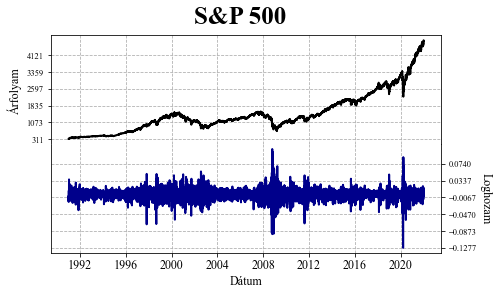

In [ ]:
name_of_the_financial_instrument="S&P 500"
##OPCIÓK: snp500, dxy, bloomberg_bond
load_csv='snp500' 
df=pd.read_csv(f"data\{load_csv}.csv")
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df=df[['Close']]

##Ábra az egész idősorról
plt.rc('font', family='Times New Roman')
fig = plt.figure(figsize=(7,4))
temp_abra=np.log(df['Close']/df['Close'].shift(1))
temp_abra=temp_abra.dropna()
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
fig.suptitle(f'{name_of_the_financial_instrument}', size=25, fontweight='bold')
axs[0].plot(df.index[1:], df['Close'][1:], color='black', linewidth=2)
axs[1].plot(df.index[1:], temp_abra, color='darkblue', linewidth=2)
axs[1].yaxis.tick_right()
axs[0].set_ylabel('Árfolyam', fontsize=12, labelpad=5)
axs[1].set_xlabel('Dátum', fontsize=12)
axs[1].yaxis.set_label_position("right")
axs[1].set_ylabel('Loghozam', fontsize=12, rotation=270, labelpad=15)
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].set_yticks(np.arange(min(df['Close'][1:]), max(df['Close'][1:]), (max(df['Close'][1:])-min(df['Close'][1:]))*0.17))
axs[1].set_yticks(np.arange(min(temp_abra), max(temp_abra), (max(temp_abra)-min(temp_abra))*0.17))
axs[1].tick_params(axis='y', labelsize=8.5)
axs[0].tick_params(axis='y', labelsize=8.5)
axs[0].yaxis.grid(True, linestyle='--')
axs[0].xaxis.grid(True, linestyle='--')
axs[1].yaxis.grid(True, linestyle='--')
axs[1].xaxis.grid(True, linestyle='--')
plt.xticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_arfolyam_teljes.svg")
plt.show(block=False)
plt.close()

In [ ]:
## Zivot-Andrews féle strukturális törés teszt:
# zivot_andrews(df['Close']["2020-03-09":"2020-03-20"])
# zivot_andrews(df['Close']["2008-11-07":"2008-11-20"])

Véletlen mintavétel

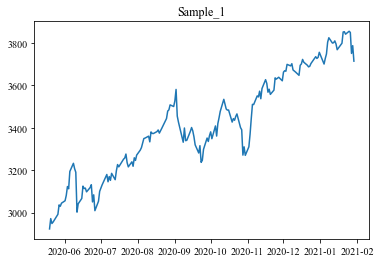

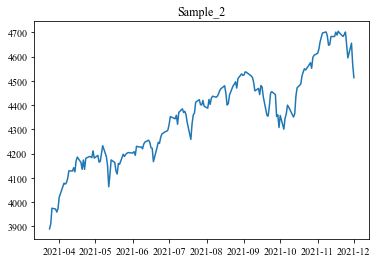

Date
2020-05-19    2922.94
2020-05-20    2971.61
2020-05-21    2948.51
2020-05-22    2955.45
2020-05-26    2991.77
               ...   
2021-01-25    3855.36
2021-01-26    3849.62
2021-01-27    3750.77
2021-01-28    3787.38
2021-01-29    3714.24
Name: Close, Length: 177, dtype: float64
Date
2021-03-24    3889.14
2021-03-25    3909.52
2021-03-26    3974.54
2021-03-29    3971.09
2021-03-30    3958.55
               ...   
2021-11-24    4701.46
2021-11-26    4594.62
2021-11-29    4655.27
2021-11-30    4567.00
2021-12-01    4513.04
Name: Close, Length: 176, dtype: float64


In [ ]:
sample_1=df['Close'][random.randint(7400,7500):random.randint(7500,7600)] #2020 után
sample_2_start=7600
sample_2=df['Close'][random.randint(sample_2_start, sample_2_start+50):random.randint(sample_2_start+50, len(df))] #2020 után

# sample_1=df['Close']['2020-04-28':'2020-10-09']
# sample_2=df['Close']['2021-02-11':'2021-08-26']

# sample_1=df['Close']['2020-05-07':'2020-10-09']
# sample_2=df['Close']['2021-03-31':'2021-06-01']

# sample_1=df['Close']['2020-05-26':'2021-01-25']
# sample_2=df['Close']['2021-04-15':'2021-06-18']

# sample_1=df['Close']['2020-06-26':'2020-11-19']
# sample_2=df['Close']['2021-03-09':'2021-10-12']

# sample_1=df['Close']['2020-06-17':'2020-12-21']
# sample_2=df['Close']['2021-03-26':'2021-10-22']

plt.plot(sample_1)
plt.title("Sample_1")
plt.show()
plt.plot(sample_2)
plt.title("Sample_2")
plt.show()

print(sample_1)
print(sample_2)

Training set beállítása - Melyik válság?

In [ ]:
##Tanuló minta hosszának beállítása:
Profit_Loss=df["2020-03-09":"2020-03-20"] 
Profit_Loss["Plus_10_days"]=Profit_Loss['Close'] 
del Profit_Loss["Close"] 
print(len(Profit_Loss)) # 10 nap
df=df['1991-01-02':"2020-03-06"] 
##Alap számolások:
index_col=df.index.values.tolist()
index_col=pd.to_datetime(index_col)
df['Eff_return']=df['Close'].pct_change()
df['Log_return']=np.log(df['Close']/df['Close'].shift(1))
df['Log_Close']=np.log(df['Close'])
##Scaling for parameter estimatization
df['Log_return_garch']=np.log(df['Close']).diff().mul(100)
df['Eff_return_garch']= 100 * (df['Close'].pct_change())
df=df.dropna()
index_col=index_col[1:]
index_col=pd.to_datetime(index_col)
r_mean=df['Log_return'].mean()
r_mean_ann=r_mean*252
r_std=df['Log_return'].std()
r_std_ann=r_std*math.sqrt(252)
##Leíró statisztika:
print(f"Évesített várható érték {round(r_mean_ann,2)}")
print(f"Évesített szórás {round(r_std_ann,2)}")
print(f"Alapvető leíró statisztika:  {df['Log_return'].describe()}")
print(f"Lapultság: {kurtosis(df['Log_return'])}")
print(f"Ferdeség: {skew(df['Log_return'])}")

10
Évesített várható érték 0.08
Évesített szórás 0.18
Alapvető leíró statisztika:  count    7364.000000
mean        0.000300
std         0.011042
min        -0.094695
25%        -0.004214
50%         0.000535
75%         0.005524
max         0.109572
Name: Log_return, dtype: float64
Lapultság: 8.965664353057925
Ferdeség: -0.2701319347733728


Value at Risk - Alap

VaR@99% Delta-Normál S&P 500 @10nap: 238.63011977085216
ES@99% Delta-Normál S&P 500 @10nap: 273.80074464042195
VaR@99% Historikus S&P 500 @10nap: 294.7647932678408


<Figure size 288x288 with 0 Axes>

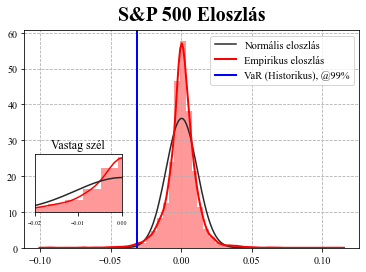

In [ ]:
##Delta-normál VaR:
alfa=0.99
var_szorzo=(norm.ppf(alfa))*-1
var_delta_napi=np.abs(r_mean+r_std*var_szorzo)
es_delta_napi=np.abs(r_mean-r_std*(np.exp(-0.5*var_szorzo**2)/(((2*np.pi)**0.5*(1-alfa)))))
var_delta_10nap=var_delta_napi*np.sqrt(10)
es_delta_10nap=es_delta_napi*np.sqrt(10)
var_10_ertek=df["Close"][-1]*var_delta_10nap
es_10_ertek=df["Close"][-1]*es_delta_10nap
print(f"VaR@99% Delta-Normál {name_of_the_financial_instrument} @10nap: {var_10_ertek}")
print(f"ES@99% Delta-Normál {name_of_the_financial_instrument} @10nap: {es_10_ertek}")
##Historikus VaR:
def quantile_exc(ser, q):
    ser_sorted = ser.sort_values()
    rank = q * (len(ser) + 1) - 1
    assert rank > 0, 'quantile is too small'
    rank_l = int(rank)
    return ser_sorted.iat[rank_l] + (ser_sorted.iat[rank_l + 1] - 
                                     ser_sorted.iat[rank_l]) * (rank - rank_l)
var_historikus_napi=np.abs(quantile_exc(df['Log_return'],1-alfa))
var_historikus_10nap=var_historikus_napi*np.sqrt(10)
var_historikus_ertek_10=df['Close'][-1]*var_historikus_10nap
print(f"VaR@99% Historikus {name_of_the_financial_instrument} @10nap: {var_historikus_ertek_10}")

#VaR ábrázoláshoz
var_line_abra=df
for i in range(1,len(df['Close'])):
	var_line_abra['var_vonal']=df['Close'][-1]-var_10_ertek
var_line_forecast=[]
for i in range(1,11):
	var_line_forecast.append(df['Close'][-1]-var_10_ertek)

##VaR ábra + Loghozam ábra
plt.rc('font', family='Times New Roman') #"serif"
fig= plt.figure(figsize=(4,4))
fig, ax =plt.subplots()
sns.distplot(df['Log_return'], hist=False, kde=False, fit=stats.norm, label="Normális eloszlás" ,ax=ax)
sns.distplot(df['Log_return'], bins=50, color='r',norm_hist=True, kde_kws=dict(linewidth=2, label="Empirikus eloszlás"), ax=ax)
plt.axvline(x=var_historikus_napi*-1, c="blue", label="VaR (Historikus), @99%", linewidth=2)
plt.xlabel("")
plt.ylabel("")
plt.title(f"{name_of_the_financial_instrument} Eloszlás", fontsize=20, fontweight="bold", pad=10)
plt.grid(True, linestyle="--")
plt.legend(loc="best", prop={'size': 10.5})
ax2 = plt.axes([0.15, 0.25, .2, .2], facecolor='white')
sns.distplot(df['Log_return'], fit=stats.norm, color="r", ax=ax2)
ax2.set_title('Vastag szél')
ax2.set_xlim([-0.02,-0.00])
ax2.tick_params(axis="both", which="major", labelsize=6)
ax2.set_xticks([-0.02,-0.01,0.00])
ax2.set_yticks([])
ax2.set_xlabel("")
ax2.set_ylabel("")
fig.savefig(f"plots\{name_of_the_financial_instrument}_var_hist.svg")
plt.show(block=False)
plt.close()

Momentumok és hatványkitevő

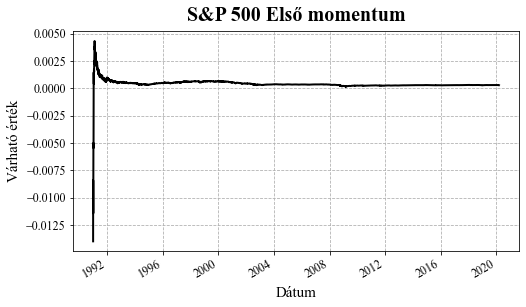

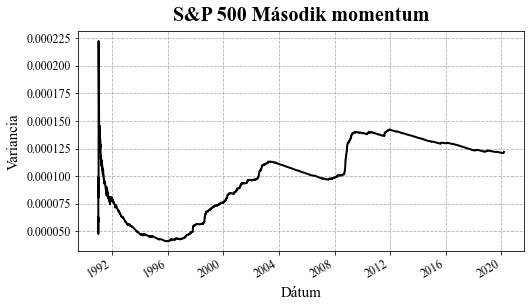

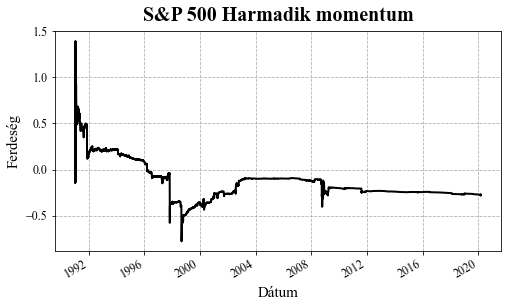

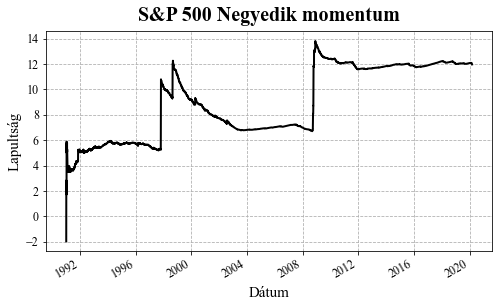

Legnagyobb (hozam) veszteség: 0.09469514468085727


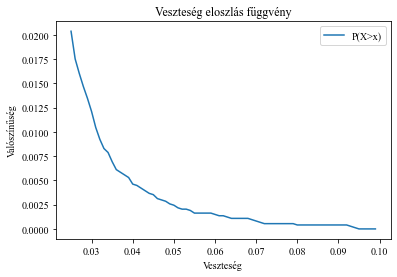

Hatványkitevő Hill: 
3.132167383583546
A veszteségek szám: 3416


In [ ]:
##Momentumok számolása:
#Első
df['Mean'] =df['Log_return'].expanding(min_periods=1).mean()
#Második
df['Var'] =df['Log_return'].expanding(min_periods=1).var()
#Harmadik
df['Skewness'] =df['Log_return'].expanding(min_periods=1).skew()
#Negyedik
df['Kurtosis'] =df['Log_return'].expanding(min_periods=1).kurt()
df['Kurtosis']=df['Kurtosis']+3

#Momentumok ábrázolása:
#Első
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col,df['Mean'], color='black', linewidth=2)
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Várható érték", fontsize=15, labelpad=5)
plt.title(f"{name_of_the_financial_instrument} Első momentum", fontsize=20, fontweight="bold", pad=10)
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_elso_momentum.svg")
plt.show(block=False)
plt.close()
#Második
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col,df['Var'], color='black', linewidth=2)
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Variancia", fontsize=15, labelpad=5)
plt.title(f"{name_of_the_financial_instrument} Második momentum", fontsize=20, fontweight="bold", pad=10)
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_masodik_momentum.svg")
plt.show(block=False)
plt.close()
#Harmadik
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col,df['Skewness'], color='black', linewidth=2)
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Ferdeség", fontsize=15, labelpad=5)
plt.title(f"{name_of_the_financial_instrument} Harmadik momentum", fontsize=20, fontweight="bold", pad=10)
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_harmadik_momentum.svg")
plt.show(block=False)
plt.close()
#Negyedik
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col,df['Kurtosis'], color='black', linewidth=2)
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Lapultság", fontsize=15, labelpad=5)
plt.title(f"{name_of_the_financial_instrument} Negyedik momentum", fontsize=20, fontweight="bold", pad=10)
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_negyedik_momentum.svg")
plt.show(block=False)
plt.close()


df['Loss']=-df['Log_return']
print(f"Legnagyobb (hozam) veszteség: {df['Loss'].max()}")

#Veszteségeloszlás:
step=1
#0,025-0,1 között nézem:
rows = [[i/1000] for i in range(25,100, step)]
Prob = pd.DataFrame(rows, columns=['x'])
Prob['P(X>x)']=0.0000
N=df['Loss'].count()
for index,row in Prob.iterrows():
    row['P(X>x)']=(df[df['Loss'] > row['x']]['Loss'].count())/N

##Veszteségek eloszlásfüggvénye
Prob.plot(x="x",y='P(X>x)')
plt.xlabel("Veszteség")
plt.ylabel("Valószínűség")
plt.title("Veszteség eloszlás függvény")
plt.show()

#Log skálán:
Prob['x_log']=np.log(Prob['x'])
Prob['P(X>x)_log']=np.log(Prob['P(X>x)'])


from sklearn.linear_model import LinearRegression
##Hatványkitevő számolása lineáris regresszióval:
lireg=LinearRegression()
X=np.array(Prob['x_log']).reshape((-1, 1))
y=np.array(Prob['P(X>x)_log']).reshape((-1, 1))
reg = lireg.fit(X, y)
print('R négyzet=',reg.score(X, y))
print('koefficiens=',reg.coef_[0][0])
print('tengelymetszet=',reg.intercept_[0])
#Alpha:
print("Hatványkitevő regresszióval: ")
alpha=reg.intercept_[0]/reg.coef_[0][0]
print('Alpha=',alpha)


##Hill-féle módszer
#N meghatározása:
N=int(50)
ord_df=df.sort_values('Loss',ascending=False)
ord_df.head()
treshold=ord_df['Loss'].iloc[N-1]
ord_df.iloc[[N-1]]
#Log(Loss/treshold)
ord_df['Loss/treshold']=ord_df['Loss']/treshold
ord_df['Ln_loss/tershold']=np.log(ord_df[ord_df['Loss/treshold']>0]['Loss/treshold'])
ord_df['Ln_loss/tershold']=np.where(ord_df['Ln_loss/tershold']<0,0,ord_df['Ln_loss/tershold'])
ord_df.head()
#Hill-féle alpha:
alpha_hill=N/(ord_df['Ln_loss/tershold'].sum())
print("Hatványkitevő Hill: ")
print(alpha_hill)
Hill_df=ord_df[ord_df['Loss']>0].copy()
print('A veszteségek szám:',len(Hill_df))

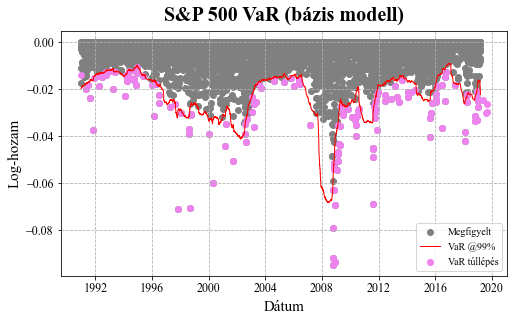

155


In [ ]:
##Value at Risk (252-napos csúsztatott szimuláció)

tau=252

var_rolling=np.zeros(shape=(len(df)))

for i in range(1, len(df)):
    var_rolling[i]= np.mean(df['Log_return'][i:tau+i])+var_szorzo*np.std(df['Log_return'][i:tau+i])

temp_scatter_var=pd.DataFrame(df['Log_return'])
temp_scatter_var[temp_scatter_var > 0]=0

var_alap_kupiec=var_rolling.squeeze()
temp_scatter_kupiec=temp_scatter_var.squeeze()
tullepesek_alap=np.where(temp_scatter_kupiec < var_alap_kupiec, 1, 0)

plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.scatter(index_col[1:len(index_col)-tau],temp_scatter_var[1:len(index_col)-tau], label='Megfigyelt', color='grey')
plt.plot(index_col[1:len(index_col)-tau],var_rolling[1:len(index_col)-tau], linewidth=1, color="red", label="VaR @99%")
plt.scatter(temp_scatter_var[tullepesek_alap == 1].index, temp_scatter_var[tullepesek_alap== 1], color="violet", label="VaR túllépés")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('Log-hozam', fontsize=15, labelpad=5)
plt.title(f'{name_of_the_financial_instrument} VaR (bázis modell)', fontsize=20, fontweight="bold", pad=10)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_var_hist_252_sim.svg")
plt.show()

print(sum(tullepesek_alap))


Expected Shortfall (base modell)

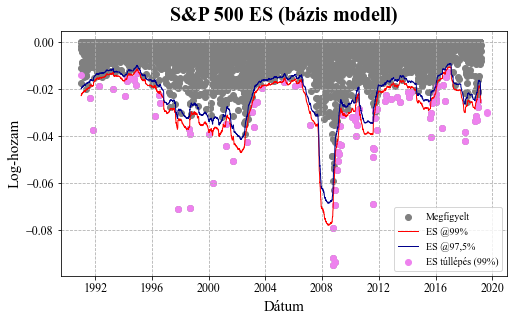

99%
96
97,5%
151


In [ ]:
##Expected Shortfall (252-napos csúsztatott szimuláció)

tau=252
es_rolling099=np.zeros(shape=(len(df)))
es_rolling0975=np.zeros(shape=(len(df)))

es_alfa=0.975

for i in range(1, len(df)):
    es_rolling099[i]= np.mean(df['Log_return'][i:tau+i])-np.std(df['Log_return'][i:tau+i])*(np.exp(-0.5*((norm.ppf(alfa))*-1)**2)/(((2*np.pi)**0.5*(1-alfa))))

for i in range(1, len(df)):
    es_rolling0975[i]= np.mean(df['Log_return'][i:tau+i])-np.std(df['Log_return'][i:tau+i])*(np.exp(-0.5*((norm.ppf(es_alfa))*-1)**2)/(((2*np.pi)**0.5*(1-es_alfa))))

temp_scatter_es=pd.DataFrame(df['Log_return'])
temp_scatter_es[temp_scatter_es > 0]=0

es_alap_kupiec099=es_rolling099.squeeze()
es_alap_kupiec0975=es_rolling0975.squeeze()
temp_scatter_kupiec_es099=temp_scatter_es.squeeze()
temp_scatter_kupiec_es0975=temp_scatter_es.squeeze()
tullepesek_alap_es099=np.where(temp_scatter_kupiec_es099 < es_alap_kupiec099, 1, 0)
tullepesek_alap_es0975=np.where(temp_scatter_kupiec_es0975 < es_alap_kupiec0975, 1, 0)


plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.scatter(index_col[1:len(index_col)-tau],temp_scatter_es[1:len(index_col)-tau], label='Megfigyelt', color='grey')
plt.plot(index_col[1:len(index_col)-tau],es_rolling099[1:len(index_col)-tau], linewidth=1, color="red", label="ES @99%")
plt.plot(index_col[1:len(index_col)-tau],es_rolling0975[1:len(index_col)-tau], linewidth=1, color="darkblue", label="ES @97,5%")
plt.scatter(temp_scatter_es[tullepesek_alap_es099 == 1].index, temp_scatter_es[tullepesek_alap_es099== 1], color="violet", label="ES túllépés (99%)")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('Log-hozam', fontsize=15, labelpad=5)
plt.title(f'{name_of_the_financial_instrument} ES (bázis modell)', fontsize=20, fontweight="bold", pad=10)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_es_hist_252_sim.svg")
plt.show()

print("99%")
print(sum(tullepesek_alap_es099))
print("97,5%")
print(sum(tullepesek_alap_es0975))

Következő 10 nap (Tényleges előrejelzési adatok) PROFIT/LOSS...

In [ ]:
Profit_Loss["P/L"]=None
Profit_Loss["P/L"][0]=Profit_Loss["Plus_10_days"][0]-df['Close'][-1]
for i in range(9):
	Profit_Loss["P/L"][i+1]=Profit_Loss["Plus_10_days"][i+1]-Profit_Loss["Plus_10_days"][i]
print(Profit_Loss)
total_pl=Profit_Loss["P/L"].sum()
print(f" {name_of_the_financial_instrument} összes veszteség/nyereség a 10 nap alatt: {total_pl}")
##Előrejelzés intevalluma
while (True):
    try:
        n=input("Hány napra jelezzen előre a modell (alap eset n=10)")
        if n == "":
            n=10
        n=int(n)
        break
    except ValueError:
        "A megadott érték nem szám!"

last_date=index_col[-1]
last_date_next_day=last_date+datetime.timedelta(days=1)
fcast_dates=[]
for i in range(n):
	fcast_dates.append(last_date_next_day+datetime.timedelta(days=i))

index_col=pd.DataFrame(index_col, columns=['Date'])
index_col['date']=index_col['Date']
index_col.set_index('Date', inplace=True)

df['Abs_Log_return']=abs(df['Log_return'])
abs_r=abs(df['Log_return'])
abs_r=abs_r*100

            Plus_10_days     P/L
Date                            
2020-03-09       2746.56 -225.81
2020-03-10       2882.23  135.67
2020-03-11       2741.38 -140.85
2020-03-12       2480.64 -260.74
2020-03-13       2711.02  230.38
2020-03-16       2386.13 -324.89
2020-03-17       2529.19  143.06
2020-03-18       2398.10 -131.09
2020-03-19       2409.39   11.29
2020-03-20       2304.92 -104.47
 S&P 500 összes veszteség/nyereség a 10 nap alatt: -667.4499999999998


Naive Előrejelzés

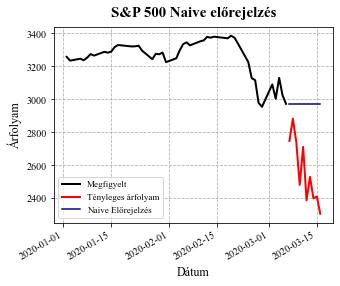

In [ ]:
train_len_naive=len(df['Close'])
y_hat_naive=np.zeros(shape=(n,1))
for i in range(0,n):
	y_hat_naive[i]=df['Close'][train_len_naive-1]
#Ábra:
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(5,4))
plt.plot(index_col['date'].loc['2020':], df['Close'].loc['2020':], label='Megfigyelt', color='black', linewidth=2)
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges árfolyam", linewidth=2)
plt.plot(fcast_dates,y_hat_naive, label='Naive Előrejelzés', color="darkblue")
plt.title(f'{name_of_the_financial_instrument} Naive előrejelzés', fontsize=15, fontweight="bold", pad=10)
plt.legend(loc='lower left', prop={'size': 9})
plt.grid(True, linestyle='--')
plt.xlabel('Dátum', fontsize=12, labelpad=5)
plt.ylabel('Árfolyam', fontsize=12, labelpad=5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_naive.svg")
plt.show(block=False)
plt.close()

Monte Carlo Előrejelzés

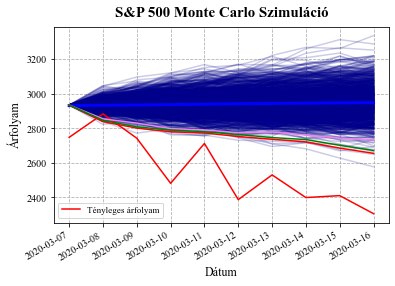

In [ ]:
simulation_n=1000
simulation_dt=1/252
last_value=df['Close'][-1]
sim_values=np.zeros(shape=(n, simulation_n)) #n=10
loghozam_mc_0=(r_mean_ann-0.5*r_std_ann**2)*simulation_dt+r_std_ann*math.sqrt(simulation_dt)*norm.ppf(random.uniform(0, 1))
sim_values[0,:]=last_value*math.exp(loghozam_mc_0)
for i in range(1,simulation_n): #n=10
	for j in range(1,n):
		sim_values[j,i]=sim_values[j-1,i]*math.exp(((r_mean_ann-0.5*r_std_ann**2)*simulation_dt+r_std_ann*math.sqrt(simulation_dt)*norm.ppf(random.uniform(0, 1))))

##Legalsó-legfelső, középső trajektória
min_values_mc = []
max_values_mc = []
for i in range(1, n+1):
    min_value_mc = min(sim_values[i-1,1:simulation_n])
    min_values_mc.append(min_value_mc)
    max_value_mc = max(sim_values[i-1,1:simulation_n])
    max_values_mc.append(max_value_mc)

mc_mid_pred=[]
for i in range(1,n+1):
    pred_mc_temp=sum(sim_values[i-1,1:simulation_n])/simulation_n
    mc_mid_pred.append(pred_mc_temp)

#Also kvantilis VaR
lower_kvant_mc_alap=[]
temp_k_mc_alap=pd.DataFrame(sim_values)
for i in range(1, n+1):
    lower_kvant_mc_temp_alap=temp_k_mc_alap.iloc[i-1,1:simulation_n].quantile(1-alfa)
    lower_kvant_mc_alap.append(lower_kvant_mc_temp_alap)

#Expected Shortfall
ES_mc_99=[]
for i in range(1, n+1):
    es_99_temp_mc=((temp_k_mc_alap.iloc[i-1,1:simulation_n].quantile(1-alfa))+(min(sim_values[i-1,1:simulation_n])))/2
    ES_mc_99.append(es_99_temp_mc)
ES_mc_975=[]
for i in range(1, n+1):
    es_975_temp_mc=((temp_k_mc_alap.iloc[i-1,1:simulation_n].quantile(1-0.975))+(min(sim_values[i-1,1:simulation_n])))/2
    ES_mc_975.append(es_975_temp_mc)


##Monte Carlo ábra
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(6,4))
for i in range(1,simulation_n):
	plt.plot(fcast_dates,sim_values[:,i], color="darkblue", alpha=0.2)
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges árfolyam")
plt.plot(fcast_dates, mc_mid_pred, linewidth=3, color="blue")
plt.plot(fcast_dates,lower_kvant_mc_alap, color="violet")
plt.plot(fcast_dates,ES_mc_99, color="red")
plt.plot(fcast_dates,ES_mc_975, color="green")
plt.xlabel('Dátum', fontsize=12, labelpad=5)
plt.ylabel('Árfolyam', fontsize=12, labelpad=5)
plt.title(f'{name_of_the_financial_instrument} Monte Carlo Szimuláció', fontsize=15, fontweight="bold", pad=10)
plt.legend(loc='lower left', prop={'size': 9})
plt.grid(True, linestyle='--')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_mc.svg")
plt.show(block=False)
plt.close()

Árfolyam & hozam ábrázolás

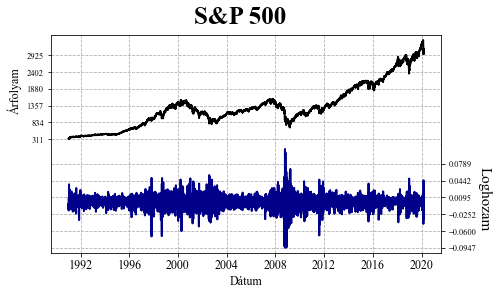

In [ ]:
plt.rc('font', family='Times New Roman')
fig = plt.figure(figsize=(7,4))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
fig.suptitle(f'{name_of_the_financial_instrument}', size=25, fontweight='bold')
axs[0].plot(index_col, df['Close'], color='black', linewidth=2)
axs[1].plot(index_col, df['Log_return'], color='darkblue', linewidth=2)
axs[1].yaxis.tick_right()
axs[0].set_ylabel('Árfolyam', fontsize=12, labelpad=5)
axs[1].set_xlabel('Dátum', fontsize=12)
axs[1].yaxis.set_label_position("right")
axs[1].set_ylabel('Loghozam', fontsize=15, rotation=270, labelpad=15)
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].set_yticks(np.arange(min(df['Close']), max(df['Close']), (max(df['Close'])-min(df['Close']))*0.17))
axs[1].set_yticks(np.arange(min(df['Log_return']), max(df['Log_return']), (max(df['Log_return'])-min(df['Log_return']))*0.17))
axs[1].tick_params(axis='y', labelsize=8.5)
axs[0].tick_params(axis='y', labelsize=8.5)
axs[0].yaxis.grid(True, linestyle='--')
axs[0].xaxis.grid(True, linestyle='--')
axs[1].yaxis.grid(True, linestyle='--')
axs[1].xaxis.grid(True, linestyle='--')
plt.xticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_arfolyam.svg")
plt.show(block=False)
plt.close()


Korrelogram

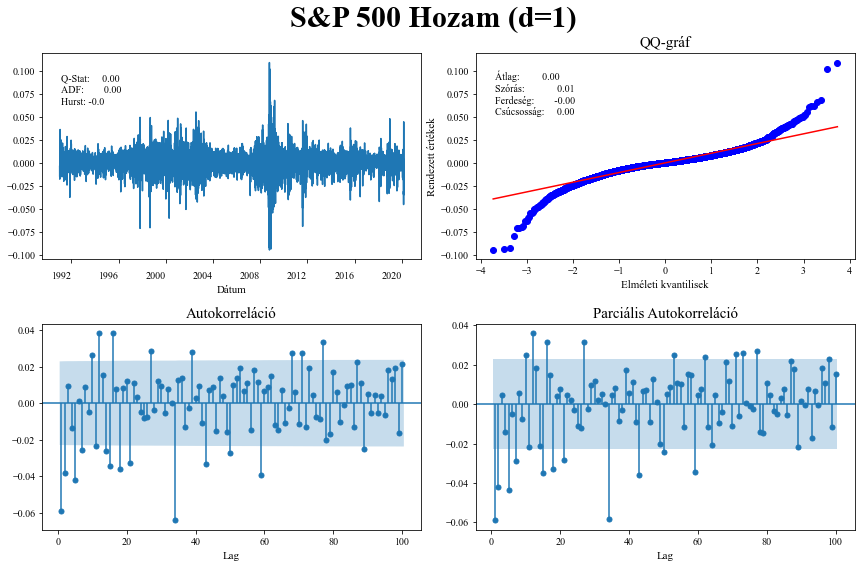

In [ ]:
plot_correlogram(df['Log_return'], lags=100, title=name_of_the_financial_instrument + ' Hozam (d=1)')
plt.show(block=False)
plt.close()

Tesztek

In [ ]:
## Normalitás tesztek:
jarque_bera_test = stats.jarque_bera(df['Log_return'])
print('JB P-érték: {0:.16f}'.format(jarque_bera_test[1]))
print(f" JB Teszt-statisztika: {jarque_bera_test[0]}")

def chisquaretest(value,dof,confidency):
    critical = 1 - stats.chi2.cdf(JB, dof)
    if confidency >= critical:
        return ('Reject H0, P value= {0:.16f}'.format(critical))
    else:
        return ('Fail to reject H0, P value= {0:.16f}'.format(critical))
skew=df['Log_return'].skew()
kurt=df['Log_return'].kurtosis()
count=df['Log_return'].count()
JB=(count/6)*(skew**2+(1/4)*(kurt-3)**2)
print("Kurtosis:" , kurt)
print("Jarque–Bera:" , JB)
print(chisquaretest(JB,2,0.05))

#Jarque–Bera (Pearson)
skew=df['Log_return'].dropna().skew()
kurt=stats.kurtosis(df['Log_return'].dropna(), fisher=False)
count=df['Log_return'].dropna().count()
JB=(count/6)*(skew**2+(1/4)*(kurt-3)**2)
print("Kurtosis:" , kurt)
print("Jarque–Bera:" , JB)
print(chisquaretest(JB,2,0.05))

#Normalitás teszt Shapiro:
shapiro_wilk_test = stats.shapiro(df['Log_return'])
print(shapiro_wilk_test)
print('Shapiro_wilk P-érték: {0:.16f}'.format(shapiro_wilk_test[1]))
print(f"Shapiro-wilk Teszt statisztika: {shapiro_wilk_test[0]}")

#Kolmogorov–Smirnov teszt:
ks_test=stats.kstest(df['Log_return'], "norm")
print(ks_test)
# Student-féle t-eloszlás
print('{0:.16f}'.format(ks_test.pvalue))

## ADF:
print("Dickey-Fuller teszt:")
dftest = adfuller(df['Log_return'].replace([np.inf, -np.inf,np.nan],0),autolag='BIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

JB P-érték: 0.0000000000000000
 JB Teszt-statisztika: 24753.78602145566
Kurtosis: 8.972570043894928
Jarque–Bera: 11034.830325087887
Reject H0, P value= 0.0000000000000000
Kurtosis: 11.965664353057925
Jarque–Bera: 24753.822520303467
Reject H0, P value= 0.0000000000000000
(0.9108574390411377, 0.0)
Shapiro_wilk P-érték: 0.0000000000000000
Shapiro-wilk Teszt statisztika: 0.9108574390411377
KstestResult(statistic=0.4799888031777445, pvalue=0.0)
0.0000000000000000
Dickey-Fuller teszt:
Test Statistic                  -65.057853
p-value                           0.000000
#lags used                        1.000000
number of observations used    7362.000000
critical value (1%)              -3.431239
critical value (5%)              -2.861933
critical value (10%)             -2.566979
dtype: float64


ARIMA

                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 7364
Model:               SARIMAX(1, 1, 1)   Log Likelihood               22750.318
Date:                Thu, 06 Oct 2022   AIC                         -45492.635
Time:                        18:06:20   BIC                         -45465.018
Sample:                             0   HQIC                        -45483.143
                               - 7364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002   8.19e-05      2.277      0.023     2.6e-05       0.000
ar.L1          0.3820      0.069      5.549      0.000       0.247       0.517
ma.L1         -0.4496      0.065     -6.877      0.0

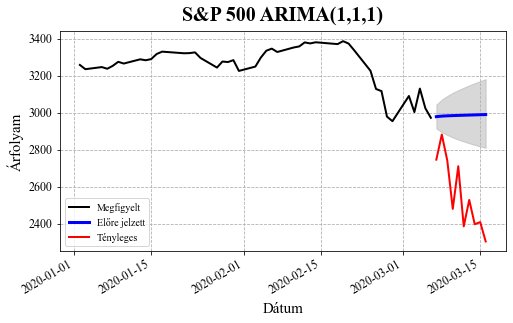

Ljung-Box Teszt: 
                 lag_1          lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  \
P-values  4.075296e-72  3.708644e-299    0.0    0.0    0.0    0.0    0.0   

          lag_8  lag_9  lag_10  lag_11  lag_12  lag_13  lag_14  lag_15  \
P-values    0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0   

          lag_16  lag_17  lag_18  lag_19  lag_20  
P-values     0.0     0.0     0.0     0.0     0.0  
Ljung-Box Teszt (sig. lagok): 
                 lag_1          lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  \
P-values  4.075296e-72  3.708644e-299    0.0    0.0    0.0    0.0    0.0   

          lag_8  lag_9  lag_10  lag_11  lag_12  lag_13  lag_14  lag_15  \
P-values    0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0   

          lag_16  lag_17  lag_18  lag_19  lag_20  
P-values     0.0     0.0     0.0     0.0     0.0  
KPSS Teszt statisztika: 0.42445685127640026
KPSS p-érték: 0.01


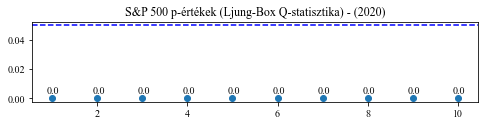

ARCH teszt LM-Teszt statisztika:  2226.6446805667897
ARCH teszt LM-Teszt p-érték:  0.0
ARCH teszt F-teszt statisztika:  88.40473252849407
ARCH teszt F-Teszt p-érték:  0.0


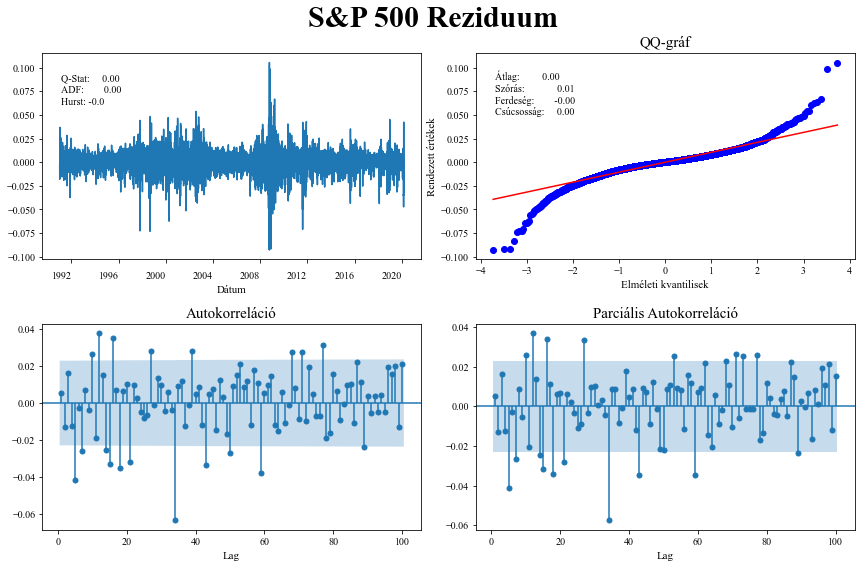

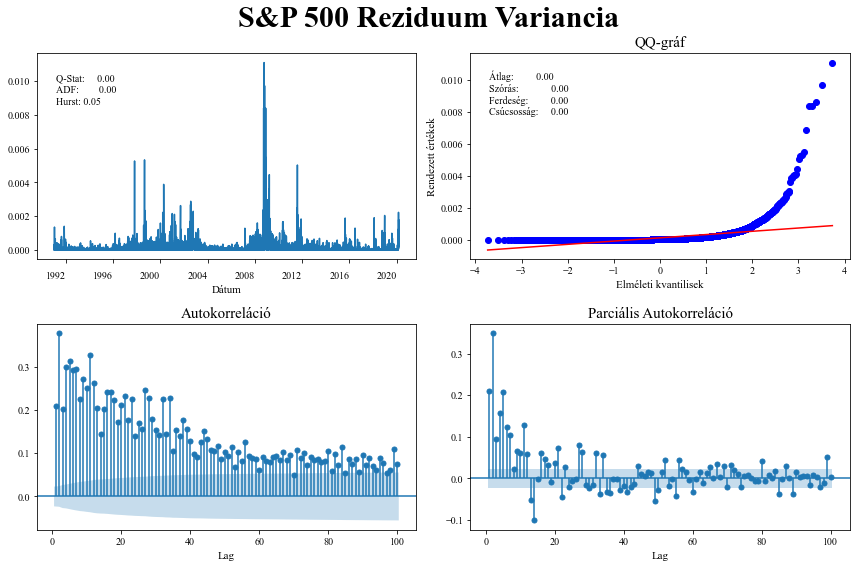

In [ ]:

log_or_normal='Log_Close'

##p és q rendjének meghatározása:
# order_aic_bic=[]
# for p in range(4):
# 	for q in range(4):
# 		try:
# 			model=SARIMAX(df[log_or_normal],trend='c', order=(p,1,q))
# 			results=model.fit()
# 			order_aic_bic.append((p,q,results.aic, results.bic))
# 		except:
# 			order_aic_bic.append((p,q, None, None))
# order_df=pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])
# print(order_df.sort_values('AIC'))
# print(order_df.sort_values('BIC'))

while (True):
	try:
		p_input=int(float(input('Adja meg az ARIMA(p,x,x) rendjét: ')))
		d_input=int(float(input(f'Adja meg az ARIMA({p_input},d,x) rendjét: ')))
		q_input=int(float(input(f'Adja meg az ARIMA({p_input},{d_input},q) rendjét: ')))
		break
	except ValueError:
		print("Egész számokat adjon meg a modell p és q rendjének, lehetőleg maximum 3-ig")
		continue

model=SARIMAX(df[log_or_normal],trend='c', order=(p_input,d_input,q_input))
results=model.fit()
print(results.summary())

forecast=results.get_forecast(steps=n)
if log_or_normal=='Close':
	mean_forecast=forecast.predicted_mean
	confidence_intervals=forecast.conf_int()
	lower_limits=confidence_intervals.loc[:,'lower Close']
	upper_limits=confidence_intervals.loc[:,'upper Close']
else:
	mean_forecast=np.exp(forecast.predicted_mean)
	confidence_intervals=np.exp(forecast.conf_int())
	lower_limits=confidence_intervals.loc[:,'lower Log_Close']
	upper_limits=confidence_intervals.loc[:,'upper Log_Close']


##ARIMA ábra
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col['date'].loc['2020':], df['Close'].loc['2020':], label='Megfigyelt', color='black', linewidth=2)
plt.plot(fcast_dates, mean_forecast, color='blue', label='Előre jelzett', linewidth=3)
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges", linewidth=2)
plt.fill_between(fcast_dates, lower_limits, upper_limits, color='grey', alpha=0.3)
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('Árfolyam', fontsize=15, labelpad=5)
plt.title(f'{name_of_the_financial_instrument} ARIMA({p_input},{d_input},{q_input})', fontsize=20, fontweight="bold", pad=10)
plt.legend(loc='lower left')
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_arima.svg")
plt.show(block=False)
plt.close()

resid_arima=results.resid
resid_arima=resid_arima[1:]
resid_arima_garch=100*resid_arima

##########################################Reziduum vizsgálat ARIMA#################################################
#Ljung-Box:
lb_test_arima=acorr_ljungbox(resid_arima**2, lags=20)
df_lb_test_arima = pd.DataFrame({'P-values': lb_test_arima[1]}).T
col_num_arima = df_lb_test_arima.shape[1]
col_names_arima = ['lag_'+str(num) for num in list(range(1,col_num_arima+1,1))]
df_lb_test_arima.columns = col_names_arima
print("Ljung-Box Teszt: ")
print(df_lb_test_arima)
mask = df_lb_test_arima < 0.05
df_lb_test_arima[mask].dropna(axis=1)
print("Ljung-Box Teszt (sig. lagok): ")
print(df_lb_test_arima)
##KPSS
kpss_resid=sm.tsa.stattools.kpss(resid_arima**2, regression='ct')
print(f"KPSS Teszt statisztika: {kpss_resid[0]}")
print(f"KPSS p-érték: {kpss_resid[1]}")

tsdiag(resid_arima**2)

#############################################Reziduum négyzet####################################################################

het_test = het_arch(abs(resid_arima))
print (f"ARCH teszt LM-Teszt statisztika:  {het_test[0]}")
print (f"ARCH teszt LM-Teszt p-érték:  {het_test[1]}")
print (f"ARCH teszt F-teszt statisztika:  {het_test[2]}")
print (f"ARCH teszt F-Teszt p-érték:  {het_test[3]}")

plot_correlogram(resid_arima, lags=100, title=name_of_the_financial_instrument +' Reziduum')
plt.show(block=False)
plt.close()

#Reziduum négyzet korrelogram
plot_correlogram(resid_arima.sub(resid_arima.mean()).pow(2), lags=100, title=name_of_the_financial_instrument +' Reziduum Variancia')
plt.show(block=False)
plt.close()

ARMA+GARCH

Egész számokat adjon meg a modell p és q rendjének, lehetőleg maximum 3-ig
                       Zero Mean - GARCH Model Results                        
Dep. Variable:       Log_return_garch   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9613.96
Distribution:                  Normal   AIC:                           19233.9
Method:            Maximum Likelihood   BIC:                           19254.6
                                        No. Observations:                 7364
Date:                Thu, Oct 06 2022   Df Residuals:                     7364
Time:                        18:06:53   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------------------------------

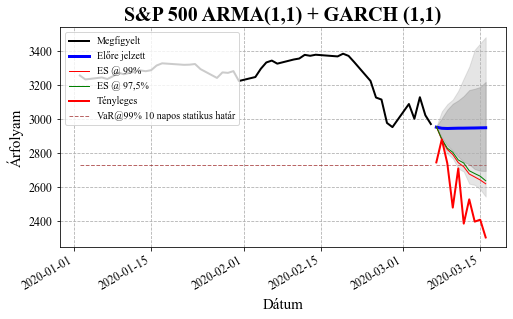

In [ ]:
opcio_garch=["abs_r","Log_return_garch", "Eff_return_garch", "resid_arima_garch", "GARCH", "EGARCH","FIARCH","ARCH","HARCH", "normal", "t", "skewt","gaussian","studentst","skewstudent","ged","generalized error",  "AR", "constant","zero","LS","ARX","HAR","HARX", "", "0", "1"]
opcio_log_eff=["Log_return_garch", "Eff_return_garch"]
while (True):
	log_or_eff_or_arima=input('Hozamok (Log_return_garch)=ALAP vagy Abszolút Hozamok (abs_r) vagy ARIMA reziduum (resid_arima_garch): ') or 'Log_return_garch'
	if log_or_eff_or_arima in opcio_garch:
		pass
	else:
		continue	
	vol_type=input('Volatilitás típus("GARCH", "EGARCH"...) - (alap=GARCH): ') or 'GARCH'
	if vol_type in opcio_garch:
		pass
	else:
		continue
	dist_type=input('Eloszlás típus("normal", "t", "skewt"...) - (alap=t): ') or 'normal'
	if dist_type in opcio_garch:
		pass
	else:
		continue
	mean_type=input('Drift típus("AR","constant","ARX"...) - (alap=None): ') or 'zero'
	if mean_type in opcio_garch:
		pass
	else:
		continue
	o_type=input('"O" értéke (lag - asszimetrikus komponens) - (alap=0, 1=GJR): ') or "0"
	if o_type in opcio_garch:
		o_type=int(float(o_type))
		break
	else:
		continue

while (True):
	try:
		p_input_garch=int(float(input('Adja meg a végleges GARCH(p,x)-t: ')))
		q_input_garch=int(float(input(f"Adja meg a végleges GARCH({p_input_garch},q)-t: ")))
		o_input_garch=int(float(input(f'Adja meg a GARCH({p_input_garch},{q_input_garch}) O(lag) (GJR-GARCH) értékét: ')))
		break
	except ValueError:
		print("Egész számokat adjon meg a modell p és q rendjének, lehetőleg maximum 3-ig")
		continue
if log_or_eff_or_arima in opcio_log_eff:
	if mean_type =='':
		gm_rev=arch_model(df[log_or_eff_or_arima], p=p_input_garch, q=q_input_garch, o=o_input_garch, vol=vol_type, dist=dist_type )
	else:
		gm_rev=arch_model(df[log_or_eff_or_arima], p=p_input_garch, q=q_input_garch, o=o_input_garch, vol=vol_type, dist=dist_type, mean=mean_type)
elif log_or_eff_or_arima not in opcio_log_eff and log_or_eff_or_arima != "resid_arima_garch":
	if mean_type =='':
		gm_rev=arch_model(abs_r, p=1, q=1, o=o_type, vol=vol_type, dist=dist_type)
	else:
		gm_rev=arch_model(abs_r, p=1, q=1, o=o_type, vol=vol_type, dist=dist_type, mean=mean_type)
else:
	if mean_type =='':
		gm_rev=arch_model(resid_arima_garch, p=p_input_garch, q=q_input_garch, o=o_input_garch, vol=vol_type, dist=dist_type)
	else:
		gm_rev=arch_model(resid_arima_garch, p=p_input_garch, q=q_input_garch, o=o_input_garch, vol=vol_type, dist=dist_type, mean=mean_type)

gm_rev_result=gm_rev.fit(disp='off')
print(gm_rev_result.summary())

#ARMA paraméterek:
params_arima=results.params.index.values.tolist()
mu=results.params['intercept']
if 'ar.L1' in params_arima:
	phi1=results.params['ar.L1']
else:
	phi1=0
if 'ma.L1' in params_arima:
	theta1=results.params['ma.L1']
else:
	theta1=0
##GARCH-paraméter (1,1)
omega=gm_rev_result.params['omega']
alpha=gm_rev_result.params['alpha[1]']
beta=gm_rev_result.params['beta[1]']

sigma_t=np.sqrt(omega + alpha * (gm_rev_result.resid**2).shift(1) + beta*(gm_rev_result.conditional_volatility**2).shift(1)) 

if dist_type == 't':
	epsilon_t=sigma_t*np.random.standard_t(gm_rev_result.params['nu'],len(sigma_t))
else:
	epsilon_t=sigma_t*np.random.standard_normal(len(sigma_t))

df['forecast_garch']=mu+phi1*df['Log_return_garch'].shift(1)+epsilon_t+theta1*epsilon_t.shift(1)
df['sigma_t']=sigma_t



kvantilis= (gm_rev_result.resid/gm_rev_result.conditional_volatility).quantile(0.01)
df['var_garch']=mu+sigma_t*kvantilis

df=df.dropna()
index_col=df.index.values.tolist()
index_col=pd.to_datetime(index_col)
index_col=pd.DataFrame(index_col, columns=['Date'])
index_col['date']=index_col['Date']
index_col.set_index('Date', inplace=True)

abs_r=abs(df['Log_return']) 
abs_r=abs_r*100

##n napos előrejelzés
while (True):
	log_or_eff_or_arima=input('Log vagy Effektív hozam alapján jelezzen előre (alap="Log")') or 'Log_return_garch'
	if log_or_eff_or_arima in opcio_garch:
		break
	else:
		continue	
if log_or_eff_or_arima in opcio_log_eff:
	train=df[log_or_eff_or_arima]
else:
	train=resid_arima_garch
if mean_type == '':
	model_f=arch_model(train, p=p_input_garch, q=q_input_garch, o=o_type, vol = vol_type , dist = dist_type)
else:
	model_f=arch_model(train, p=p_input_garch, q=q_input_garch, o=o_type, vol = vol_type , dist = dist_type, mean = mean_type)
model_f_fit = model_f.fit(disp='off')


pred = model_f_fit.forecast(horizon=n)
pred_std = np.sqrt((pred.variance.values[-1,:])/10000)
pred_std=list(pred_std)

bound_n=1000
bounds=np.zeros(shape=(n,bound_n))
pred_return=np.zeros(shape=(n,bound_n))

if dist_type == 't':
	pred_return[0,:]= (mu+phi1*df['Log_return'][-1]+theta1*pred_std[0]*np.random.standard_t(gm_rev_result.params['nu'],1))+(pred_std[0]*np.random.standard_t(gm_rev_result.params['nu'],1))
else:
	pred_return[0,:]= (mu+phi1*df['Log_return'][-1]+theta1*pred_std[0]*np.random.standard_normal(1))+(pred_std[0]*np.random.standard_normal(1))

bounds[0,:]=df['Close'][-1]*math.exp(pred_return[0,0])

for i in range(1,n):
	for j in range(1,bound_n):
		if dist_type == 't':
			pred_return[i,j]=(mu+phi1*pred_return[i-1,j]+theta1*pred_std[i-1]*np.random.standard_t(gm_rev_result.params['nu'],1))+(pred_std[i]*np.random.standard_t(gm_rev_result.params['nu'],1))
		else:
			pred_return[i,j]=(mu+phi1*pred_return[i-1,j]+theta1*pred_std[i-1]*np.random.standard_normal(1))+(pred_std[i]*np.random.standard_normal(1))
		bounds[i,j]=bounds[i-1,j]*math.exp(pred_return[i,j])


max_values_ar_garch = []
min_values_ar_garch = []
for i in range(1, n+1):
    min_value_ar_garch = min(bounds[i-1,1:bound_n])
    min_values_ar_garch.append(min_value_ar_garch)
    max_value_ar_garch = max(bounds[i-1,1:bound_n])
    max_values_ar_garch.append(max_value_ar_garch)

difference=[]
lower_kvant_garch=[]
upper_kvant_garch=[]

for i in range(1, n+1):
    temp_avg=sum(bounds[i-1,1:bound_n])/bound_n
    difference.append(temp_avg)

temp_k=pd.DataFrame(bounds)
#also-kvantilis
for i in range(1, n+1):
    lower_kvant_garch_temp=temp_k.iloc[i-1,1:bound_n].quantile(1-alfa)
    lower_kvant_garch.append(lower_kvant_garch_temp)
#felso-kvantilis
for i in range(1, n+1):
    upper_kvant_garch_temp=temp_k.iloc[i-1,1:bound_n].quantile(alfa)
    upper_kvant_garch.append(upper_kvant_garch_temp)


#Expected Shortfall
ES_garch_99=[]
for i in range(1, n+1):
    es_99_temp_garch=((temp_k.iloc[i-1,1:bound_n].quantile(1-alfa))+(min(bounds[i-1,1:bound_n])))/2
    ES_garch_99.append(es_99_temp_garch)
ES_garch_975=[]
for i in range(1, n+1):
    es_975_temp_mc=((temp_k.iloc[i-1,1:bound_n].quantile(1-0.975))+(min(bounds[i-1,1:bound_n])))/2
    ES_garch_975.append(es_975_temp_mc)

##Ábra
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col['date'].loc['2020':], df['Close'].loc['2020':], label='Megfigyelt', color='black', linewidth=2)
plt.fill_between(fcast_dates,min_values_ar_garch, max_values_ar_garch, color='grey', alpha=0.2)
plt.fill_between(fcast_dates,lower_kvant_garch, upper_kvant_garch, color='grey', alpha=0.3)
plt.plot(fcast_dates, difference, linewidth=3, color="blue", label="Előre jelzett")
plt.plot(fcast_dates, ES_garch_99, linewidth=1, color="red", label="ES @ 99%")
plt.plot(fcast_dates, ES_garch_975, linewidth=1, color="green", label="ES @ 97,5%")
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges", linewidth=2)
plt.plot(index_col['date'].loc['2020':],var_line_abra['var_vonal'].loc['2020':], linestyle='dashed', color="darkred", label="VaR@99% 10 napos statikus határ", alpha=0.6, linewidth=1)
plt.plot(fcast_dates,var_line_forecast, linestyle='dashed', color="darkred",alpha=0.4, linewidth=1)
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Árfolyam", fontsize=15, labelpad=5)
plt.title(f"{name_of_the_financial_instrument} ARMA({p_input},{q_input}) + {vol_type} ({p_input_garch},{q_input_garch})", fontsize=20, fontweight="bold")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_arma_garch.svg")
plt.show(block=False)
plt.close()

residuals_garch=model_f_fit.resid/100
vol_garch=model_f_fit.conditional_volatility/100
std_residuals_garch=residuals_garch/vol_garch


GARCH reziduum vizsgálat

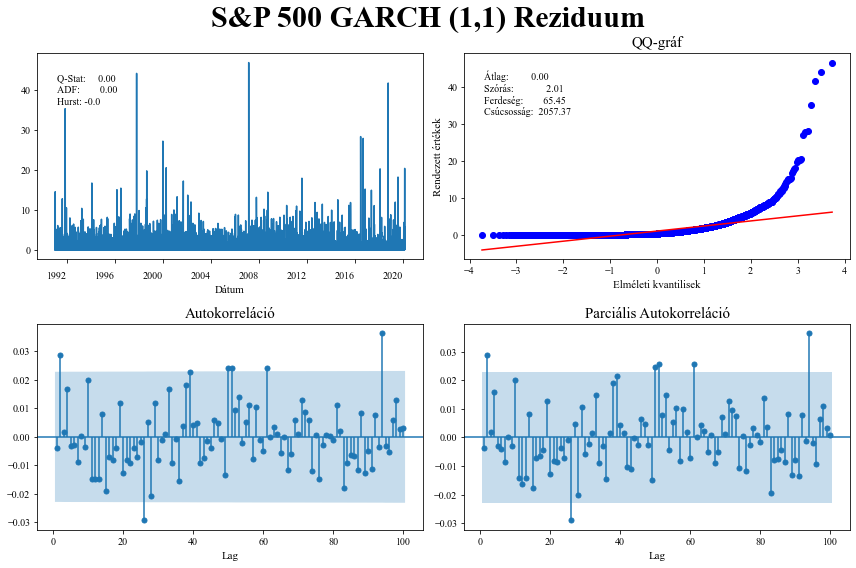

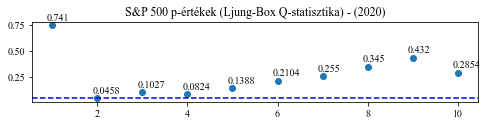

<Figure size 288x216 with 0 Axes>

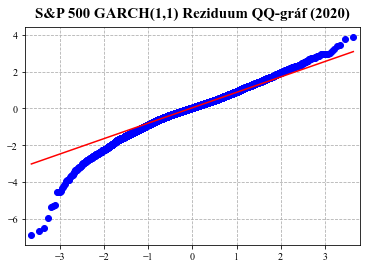

In [ ]:
plot_correlogram(std_residuals_garch**2, lags=100, title=name_of_the_financial_instrument + ' GARCH (1,1) Reziduum')
plt.show(block=False)
plt.close()
tsdiag(std_residuals_garch**2)

from statsmodels.graphics.gofplots import qqplot

plt.rc('font', family='Times New Roman')
fig1= plt.figure(figsize=(4,3))
fig1=qqplot(std_residuals_garch, line='q', dist = stats.norm, fit = True)
plt.xlabel("")
plt.ylabel("")
plt.title(f"{name_of_the_financial_instrument} GARCH(1,1) Reziduum QQ-gráf (2020)", fontsize=15, fontweight="bold", pad=10)
plt.grid(True, linestyle="--")
fig1.savefig(f"plots\{name_of_the_financial_instrument}_qq_plot_GARCH.svg")
plt.show(block=False)
plt.close()

GARCH Value at Risk ábra

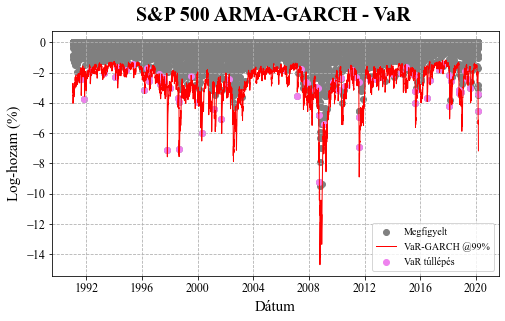

74


In [ ]:
temp_scatter=df['Log_return_garch']
temp_scatter.loc[df['Log_return_garch'] >= 0]=0

kupiec_base= temp_scatter
kupiec_garch_base= df['var_garch']
var_tullepes_arma_garch=np.where(kupiec_base < kupiec_garch_base,1,0)

plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.scatter(index_col['date'],temp_scatter, label='Megfigyelt', color='grey')
plt.plot(index_col['date'],df['var_garch'], linewidth=1, color="red", label="VaR-GARCH @99%")
plt.scatter(temp_scatter[var_tullepes_arma_garch==1].index,temp_scatter[var_tullepes_arma_garch==1], color="violet", label="VaR túllépés")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('Log-hozam (%)', fontsize=15, labelpad=5)
plt.title(f'{name_of_the_financial_instrument} ARMA-GARCH - VaR ', fontsize=20, fontweight="bold", pad=10)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_garch_var.svg")
plt.show(block=False)
plt.close()

print(sum(var_tullepes_arma_garch))

GARCH Expected Shortfall

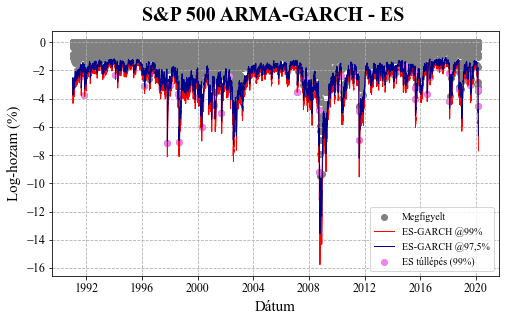

99%
51
97,5%
103
Teszt
-2.723090505519199
-2.9250091934135014
-2.517295458708953


In [ ]:
temp_scatter=df['Log_return_garch']
temp_scatter.loc[df['Log_return_garch'] >= 0]=0

kupiec_base= temp_scatter


cvar_99_temp=df['forecast_garch']
cvar_99=cvar_99_temp[cvar_99_temp<=df['var_garch']].mean()
cvar_99=cvar_99/gm_rev_result.conditional_volatility.mean()

cvar_975_temp=df['forecast_garch']
df['temp_v_975']=mu+sigma_t*((gm_rev_result.resid/gm_rev_result.conditional_volatility).quantile(0.025))

cvar_975=cvar_975_temp[cvar_975_temp<=df['temp_v_975']].mean()
cvar_975=cvar_975/gm_rev_result.conditional_volatility.mean()


df['es_garch_hist_099']=mu+sigma_t*cvar_99
df['es_garch_hist_0975']=mu+sigma_t*cvar_975


kupiec_garch_base_es_099= df['es_garch_hist_099']
es_tullepes_arma_garch_099=np.where(kupiec_base < kupiec_garch_base_es_099,1,0)
kupiec_garch_base_es_0975= df['es_garch_hist_0975']
es_tullepes_arma_garch_0975=np.where(kupiec_base < kupiec_garch_base_es_0975,1,0)


plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.scatter(index_col['date'],temp_scatter, label='Megfigyelt', color='grey')
plt.plot(index_col['date'],df['es_garch_hist_099'], linewidth=1, color="red", label="ES-GARCH @99%")
plt.plot(index_col['date'],df['es_garch_hist_0975'], linewidth=1, color="darkblue", label="ES-GARCH @97,5%")
plt.scatter(temp_scatter[es_tullepes_arma_garch_099==1].index,temp_scatter[es_tullepes_arma_garch_099==1], color="violet", label="ES túllépés (99%)")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('Log-hozam (%)', fontsize=15, labelpad=5)
plt.title(f'{name_of_the_financial_instrument} ARMA-GARCH - ES ', fontsize=20, fontweight="bold", pad=10)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_garch_es.svg")
plt.show(block=False)
plt.close()


print("99%")
print(sum(es_tullepes_arma_garch_099))
print("97,5%")
print(sum(es_tullepes_arma_garch_0975))


print("Teszt")
print(kvantilis)
print(cvar_99)
print(cvar_975)

NEURÁLIS HÁLÓ IMPORT

In [ ]:
import tensorflow as tf
import keras_tuner as kt
from keras_tuner import HyperParameter as hp
from tensorflow.keras.callbacks import History
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import  StandardScaler

LSTM-RNN

In [ ]:
df1=abs_r
scaler=StandardScaler()
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
training_size=int(len(df1)*0.7)
test_size=len(df1)-training_size
train_data, test_data=df1[0:training_size,:], df1[training_size:len(df1), :1]

time_step= 21

##Tanulási minta
X_train, y_train=create_dataset(train_data, time_step)
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
##Validációs minta
X_test, y_test= create_dataset(test_data, time_step)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

LSTM modell építés

In [ ]:
##Modell építés
number_of_epochs=30
base_model_lstm = Sequential()
base_model_lstm.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
base_model_lstm.add(Dropout(0.1))
base_model_lstm.add(LSTM(units = 10, return_sequences = True))
base_model_lstm.add(Dropout(0.1))
base_model_lstm.add(LSTM(units = 10, return_sequences = True))
base_model_lstm.add(Dropout(0.1))
base_model_lstm.add(LSTM(units = 10))
base_model_lstm.add(Dropout(0.1))
base_model_lstm.add(Dense(units = 1))
base_model_lstm.compile(optimizer = keras.optimizers.Adam(lr=0.001), loss = 'mean_squared_error', metrics=['accuracy'])
base_model_lstm.summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_fit_lstm_base=base_model_lstm.fit(X_train, y_train,validation_data=(X_test,y_test), epochs = number_of_epochs, batch_size = 32, callbacks=[stop_early],verbose=2)

##Modell Költség függvénye - alap:
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(4,3))
plt.plot(model_fit_lstm_base.history['loss'], label='loss', linewidth=2)
plt.plot(model_fit_lstm_base.history['val_loss'], label='validation_loss', linewidth=2)
plt.title("RNN-LSTM Loss Függvény (alap)", fontsize=16, fontweight="bold")
plt.legend(loc="best", prop={'size': 7})
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_loss_lstm_alap.svg")
plt.show(block=False)
plt.close()


def evaluate_model_lstm(model, X_test, y_test):
    eval_dict = model.evaluate(X_test, y_test, return_dict=True)
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    return display_df

results_nn_lstm = evaluate_model_lstm(base_model_lstm, X_test, y_test)
results_nn_lstm.index = ['Baseline']

base_model_lstm.save(f'saved_models\{name_of_the_financial_instrument}_2020_my_model_base_lstm.h5')

##Paraméter-optimalizáció:
def build_model_lstm(hp):
    regressor = Sequential()
    regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    for i in range(1, hp.Int("num_layers", 2, 5)):
        regressor.add(LSTM(units = hp.Int("units_" + str(i), min_value=10, max_value=70, step=10), return_sequences = True))
        regressor.add(Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))

    regressor.add(LSTM(units = 10))
    regressor.add(Dense(units = 1))

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    regressor.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss = 'mean_squared_error', metrics=['accuracy'])
    
    return regressor


tuner_lstm = kt.Hyperband(build_model_lstm,
                     objective="val_accuracy",
                     max_epochs=30,
                     factor=3,
                     hyperband_iterations=1,
                     directory="kt_dir",
                     project_name="kt_hyperband",
                     overwrite=True)
tuner_lstm.search_space_summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner_lstm.search(X_train, y_train,validation_data=(X_test,y_test), epochs=number_of_epochs, callbacks=[stop_early], verbose=2)

best_hps=tuner_lstm.get_best_hyperparameters()[0]
h_model_lstm = tuner_lstm.hypermodel.build(best_hps)
h_model_lstm.summary()

model_fit_lstm=h_model_lstm.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=number_of_epochs, callbacks=[stop_early], verbose=2)

##Modell Költség függvénye - Optimalizált:
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(4,3))
plt.plot(model_fit_lstm.history['loss'], label='loss', linewidth=2)
plt.plot(model_fit_lstm.history['val_loss'], label='validation_loss', linewidth=2)
plt.title("RNN-LSTM Loss Függvény (hiper)", fontsize=16, fontweight="bold")
plt.legend(loc="best", prop={'size': 7})
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_loss_lstm_hyper.svg")
plt.show(block=False)
plt.close()

hyper_df_lstm = evaluate_model_lstm(h_model_lstm, X_test, y_test)
hyper_df_lstm.index = ["Hypertuned"]

print("Alap vs. Hyper_tuned modell (LSTM-RNN): ")
print(results_nn_lstm)
print(hyper_df_lstm)

h_model_lstm.save(f'saved_models\{name_of_the_financial_instrument}_2020_my_model_hyper_lstm.h5')

LSTM Modell betöltése

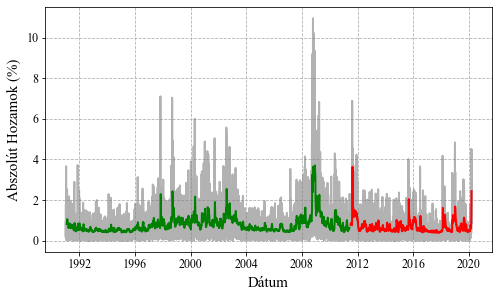

1 day input [-0.24029228 -0.01081425 -0.69438061 -0.11528545 -0.70111588 -0.6755309
 -0.54370253 -0.32806548 -0.4342617   0.38795221  3.25179471  2.84499509
 -0.43878811  4.60126437  0.10766462  4.58210542  2.57249855  4.13457941
  3.30327365  1.19508985  2.72624421]
1 day output [[2.8402886]]
2 day input [-0.01081425 -0.69438061 -0.11528545 -0.70111588 -0.6755309  -0.54370253
 -0.32806548 -0.4342617   0.38795221  3.25179471  2.84499509 -0.43878811
  4.60126437  0.10766462  4.58210542  2.57249855  4.13457941  3.30327365
  1.19508985  2.72624421  2.84028864]
2 day output [[2.804254]]
3 day input [-0.69438061 -0.11528545 -0.70111588 -0.6755309  -0.54370253 -0.32806548
 -0.4342617   0.38795221  3.25179471  2.84499509 -0.43878811  4.60126437
  0.10766462  4.58210542  2.57249855  4.13457941  3.30327365  1.19508985
  2.72624421  2.84028864  2.80425406]
3 day output [[2.6411016]]
4 day input [-0.11528545 -0.70111588 -0.6755309  -0.54370253 -0.32806548 -0.4342617
  0.38795221  3.25179471  2.84

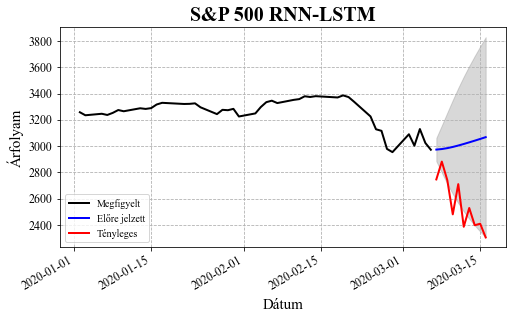

In [ ]:
from tensorflow.python.keras.models import load_model
if name_of_the_financial_instrument == "S&P 500":
	regressor = load_model('saved_models\S_P 500_2020_my_model_hyper_lstm.h5')
else:
	regressor = load_model(f'saved_models\{name_of_the_financial_instrument}_2020_my_model_hyper_lstm.h5')

train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)


look_back=time_step
trainPredictPlot=np.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot=np.empty_like(df1)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
trainPredictPlot=trainPredictPlot.reshape(-1)
testPredictPlot=testPredictPlot.reshape(-1)

plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col, scaler.inverse_transform(df1), color="grey", linewidth=2, alpha=0.6)
plt.plot(index_col,trainPredictPlot,color="green", linewidth=2)
plt.plot(index_col,testPredictPlot, color="red", linewidth=2)
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('Abszolút Hozamok (%)', fontsize=15, labelpad=5)
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_lstm_fitted.svg")
plt.show(block=False)
plt.close()

n_steps=time_step
test_data_len=(len(test_data)-n_steps)
x_input=test_data[test_data_len:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
i=0 
while(i<n):
	if(len(temp_input)>n_steps):
		x_input=np.array(temp_input[1:])
		print("{} day input {}".format(i,x_input))
		x_input=x_input.reshape((1, n_steps, 1))
		yhat=regressor.predict(x_input, verbose=0)
		print("{} day output {}".format(i,yhat))
		temp_input.extend(yhat[0].tolist())
		temp_input=temp_input[1:]
		lst_output.extend(yhat.tolist())
		i=i+1
	else:
		x_input=x_input.reshape((1, n_steps,1))
		yhat= regressor.predict(x_input, verbose=0)
		temp_input.extend(yhat[0].tolist())
		lst_output.extend(yhat.tolist())
		i=i+1

day_new=np.arange(1,n_steps+1)
day_pred=np.arange(n_steps+1,n_steps+1+n)
len_df=len(df1)

lst_output_transformed=scaler.inverse_transform(lst_output)
lst_output_transformed=lst_output_transformed[:,0]
print(lst_output)

pred_org_nn_upper=[]
pred_org_nn_lower=[]
pred_org_nn_upper.append(df['Close'][-1] * math.exp(lst_output_transformed[0]/100))
pred_org_nn_lower.append(df['Close'][-1] * math.exp(-lst_output_transformed[0]/100))
for i in range(1,n):
	pred_org_nn_upper.append(pred_org_nn_upper[i-1]*math.exp(lst_output_transformed[i]/100))
	pred_org_nn_lower.append(pred_org_nn_lower[i-1]*math.exp(-lst_output_transformed[i]/100))

pred_org_nn_middle=[]
for i in range(n):
	pred_org_nn_middle.append((pred_org_nn_upper[i]+pred_org_nn_lower[i])/2)
pred_org_nn_lower=pd.Series(pred_org_nn_lower, index=pd.RangeIndex(start=len(df['Close']), stop=len(df['Close'])+n, step=1))
pred_org_nn_upper=pd.Series(pred_org_nn_upper, index=pd.RangeIndex(start=len(df['Close']), stop=len(df['Close'])+n, step=1))

#Ábra:
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col['date'].loc['2020':], df['Close'].loc['2020':], label='Megfigyelt', color='black', linewidth=2)
plt.plot(fcast_dates, pred_org_nn_middle, color='blue', label='Előre jelzett', linewidth=2)
plt.fill_between(fcast_dates, pred_org_nn_lower, pred_org_nn_upper, color='grey', alpha=0.3)
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges", linewidth=2)
plt.title(f"{name_of_the_financial_instrument} RNN-LSTM", fontsize=20, fontweight="bold")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Árfolyam", fontsize=15, labelpad=5)
plt.legend(loc='lower left')
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_LSTM_pred.svg")
plt.show(block=False)
plt.close()

Neural-ARMA-Garch Modell

In [ ]:
df2=pd.DataFrame(df, columns=["forecast_garch","sigma_t"])
df2["forecast_garch"]=np.abs(df2['forecast_garch'])


scaler=StandardScaler()
df2=scaler.fit_transform(np.array(df2).reshape(-1,2))
training_size1=int(len(df2)*0.7)
test_size1=len(df2)-training_size1
train_data1, test_data1=df2[0:training_size1,:], df2[training_size1:len(df2), :2]

##Dataset építés
def create_dataset_2D(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a= dataset[i:(i+time_step),:]
		dataX.append(a)
		dataY.append(dataset[i+time_step,0])
	return np.array(dataX), np.array(dataY)

time_step= 21


X_train1, y_train1=create_dataset_2D(train_data1, time_step)
X_train1=X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 2)

X_test1, y_test1= create_dataset_2D(test_data1, time_step)
X_test1=X_test1.reshape(X_test1.shape[0], X_test1.shape[1], 2)

ARMA-GARCH-LSTM Modell építés

In [ ]:
##Modell építés
number_of_epochs1=30
base_model = Sequential()
base_model.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train1.shape[1], 2)))
base_model.add(Dropout(0.1))
base_model.add(LSTM(units = 10, return_sequences = True))
base_model.add(Dropout(0.1))
base_model.add(LSTM(units = 10, return_sequences = True))
base_model.add(Dropout(0.1))
base_model.add(LSTM(units = 10))
base_model.add(Dropout(0.1))
base_model.add(Dense(units = 1))
base_model.compile(optimizer = keras.optimizers.Adam(lr=0.001), loss = 'mean_squared_error', metrics=['accuracy'])
base_model.summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_fit_lstm_base1=base_model.fit(X_train1, y_train1,validation_data=(X_test1,y_test1), epochs = number_of_epochs1, batch_size = 32, callbacks=[stop_early],verbose=2)

##Modell költség függvénye - alap:
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(4,3))
plt.plot(model_fit_lstm_base1.history['loss'], label='loss', linewidth=2)
plt.plot(model_fit_lstm_base1.history['val_loss'], label='validation_loss', linewidth=2)
plt.title("ARMA-GARCH-LSTM Loss Függvény (alap)", fontsize=14, fontweight="bold")
plt.legend(loc="best", prop={'size': 7})
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_loss_arma_garch_lstm_alap.svg")
plt.show(block=False)
plt.close()

def evaluate_model(model, X_test1, y_test1):
    eval_dict = model.evaluate(X_test1, y_test1, return_dict=True)
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    return display_df

results_nn = evaluate_model(base_model, X_test1, y_test1)
results_nn.index = ['Baseline']

base_model.save(f'saved_models\{name_of_the_financial_instrument}_2020_my_model_neural_ARMA_GARCH_base.h5')

def build_model(hp):
    regressor = Sequential()
    regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train1.shape[1], 2)))
    for i in range(1, hp.Int("num_layers", 2, 5)):
        regressor.add(LSTM(units = hp.Int("units_" + str(i), min_value=10, max_value=70, step=10), return_sequences = True))
        regressor.add(Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    regressor.add(LSTM(units = 10))
    regressor.add(Dense(units = 1))
    
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    regressor.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss = 'mean_squared_error', metrics=['accuracy'])
    
    return regressor

tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=30,
                     factor=3,
                     hyperband_iterations=1,
                     directory="kt_dir",
                     project_name="kt_hyperband",
                     overwrite=True)
tuner.search_space_summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train1, y_train1,validation_data=(X_test1,y_test1), epochs=number_of_epochs1, callbacks=[stop_early], verbose=2)
best_hps=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()
model_fit1=h_model.fit(X_train1, y_train1,validation_data=(X_test1,y_test1), epochs=number_of_epochs1, callbacks=[stop_early], verbose=2)

#Költség függvény - hibrid:
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(4,3))
plt.plot(model_fit1.history['loss'], label='loss', linewidth=2)
plt.plot(model_fit1.history['val_loss'], label='validation_loss', linewidth=2)
plt.title("ARMA-GARCH-LSTM Loss Függvény (hibrid)", fontsize=14, fontweight="bold")
plt.legend(loc="best", prop={'size': 7})
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_loss_arma_garch_lstm_hyper.svg")
plt.show(block=False)
plt.close()

hyper_df = evaluate_model(h_model, X_test1, y_test1)
hyper_df.index = ["Hypertuned"]

print("Alap vs. Hyper_tuned modell (ARMA-GARCH-LSTM): ")
print(results_nn)
print(hyper_df)

h_model.save(f'saved_models\{name_of_the_financial_instrument}_2020_my_model_neural_ARMA_GARCH_hyper.h5')

ARMA-GARCH-LSTM Modell betöltés


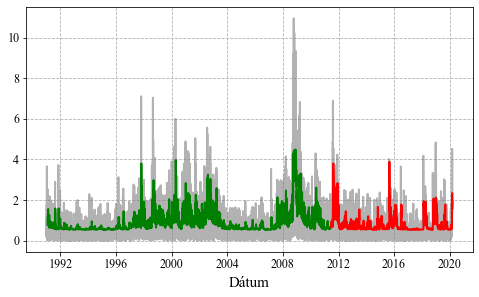

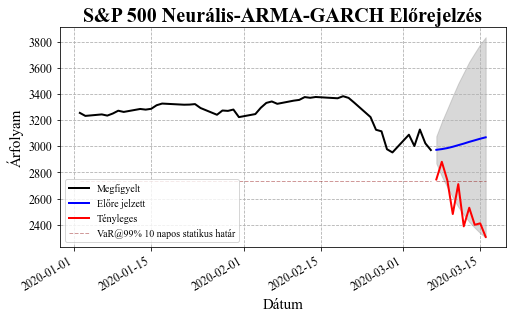

In [ ]:
from tensorflow.python.keras.models import load_model
if name_of_the_financial_instrument == "S&P 500":
	regressor1 = load_model('saved_models\S_P 500_2020_my_model_neural_ARMA_GARCH_hyper.h5')
else:
	regressor1 = load_model(f'saved_models\{name_of_the_financial_instrument}_2020_my_model_neural_ARMA_GARCH_hyper.h5')

train_predict1=regressor1.predict(X_train1)
trainPredict_dataset_like1 = np.zeros(shape=(len(train_predict1), 2) )
trainPredict_dataset_like1[:,0] = train_predict1[:,0]
train_predict1 = scaler.inverse_transform(trainPredict_dataset_like1)[:,0]
test_predict1=regressor1.predict(X_test1)
testPredict_dataset_like1 = np.zeros(shape=(len(test_predict1), 2) )
testPredict_dataset_like1[:,0] = test_predict1[:,0]
test_predict1 = scaler.inverse_transform(testPredict_dataset_like1)[:,0]
train_predict1=train_predict1.reshape(-1,1)
test_predict1=test_predict1.reshape(-1,1)

look_back1=time_step #100
trainPredictPlot1=np.empty_like(df2[:,1])
trainPredictPlot1=trainPredictPlot1.reshape(-1,1)
trainPredictPlot1[:,:]=np.nan
testPredictPlot1=np.empty_like(df2[:,1])
testPredictPlot1=testPredictPlot1.reshape(-1,1)
testPredictPlot1[:,:]=np.nan
trainPredictPlot1[look_back1:len(train_predict1)+look_back1, :] = train_predict1
testPredictPlot1[len(train_predict1)+(look_back1*2)+1:len(df2)-1, :] = test_predict1
trainPredictPlot1=trainPredictPlot1.reshape(-1)
testPredictPlot1=testPredictPlot1.reshape(-1)
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col, abs_r.values, color="grey", linewidth=2, alpha=0.6)
plt.plot(index_col,trainPredictPlot1,color="green", linewidth=2)
plt.plot(index_col,testPredictPlot1, color="red", linewidth=2)
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('', fontsize=15, labelpad=5)
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_arma_garch_lstm_fitted.svg")
plt.show(block=False)
plt.close()

n_steps1=time_step
test_data_len1=(len(test_data1)-n_steps1)
x_input1=test_data1[test_data_len1:]
x_input1= x_input1.reshape(2,-1)
temp_input1= x_input1

lst_output1=[]
i=0 
while(i<n):
	if(len(temp_input1[0])>n_steps1):
		x_input1= temp_input1[:,1:]
		x_input1=x_input1.reshape((1, n_steps1, 2))
		yhat1=regressor1.predict(x_input1, verbose=0) 
		tmp1=np.append(tmp1,yhat1[0]) 
		tmp2=np.append(tmp2,yhat1[0])
		tmp1=tmp1[1:]
		tmp2=tmp2[1:]
		temp_input1=np.vstack((tmp1,tmp2))
		lst_output1.extend(yhat1.tolist())
		i=i+1
	else:
		x_input1=x_input1.reshape((1, n_steps1,2))
		yhat1= regressor1.predict(x_input1, verbose=0)
		tmp1=np.append(temp_input1[0],yhat1[0])
		tmp2=np.append(temp_input1[1],yhat1[0])
		temp_input1=np.vstack((tmp1, tmp2))
		lst_output1.extend(yhat1.tolist())
		i=i+1

day_new1=np.arange(1,n_steps1+1)
day_pred1=np.arange(n_steps1+1,n_steps1+1+n)
len_df1=len(df2)

lst_output1=np.array(lst_output1)
lst_output_dataset_like1 = np.zeros(shape=(10, 2) )
lst_output_dataset_like1[:,0] = lst_output1[:,0]
lst_output_transformed1 = scaler.inverse_transform(lst_output_dataset_like1)[:,0]

pred_org_nn_upper1=[]
pred_org_nn_lower1=[]
pred_org_nn_upper1.append(df['Close'][-1] * math.exp(lst_output_transformed1[0]/100))
pred_org_nn_lower1.append(df['Close'][-1] * math.exp(-lst_output_transformed1[0]/100))
for i in range(1,n):
	pred_org_nn_upper1.append(pred_org_nn_upper1[i-1]*math.exp(lst_output_transformed1[i]/100))
	pred_org_nn_lower1.append(pred_org_nn_lower1[i-1]*math.exp(-lst_output_transformed1[i]/100))

pred_org_nn_middle1=[]
for i in range(n):
	pred_org_nn_middle1.append((pred_org_nn_upper1[i]+pred_org_nn_lower1[i])/2)
pred_org_nn_lower1=pd.Series(pred_org_nn_lower1, index=pd.RangeIndex(start=len(df['Close']), stop=len(df['Close'])+n, step=1))
pred_org_nn_upper1=pd.Series(pred_org_nn_upper1, index=pd.RangeIndex(start=len(df['Close']), stop=len(df['Close'])+n, step=1))

#Ábra:
plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(index_col['date'].loc['2020':], df['Close'].loc['2020':], label='Megfigyelt', color='black', linewidth=2)
plt.plot(fcast_dates, pred_org_nn_middle1, color='blue', label='Előre jelzett', linewidth=2)
plt.fill_between(fcast_dates, pred_org_nn_lower1, pred_org_nn_upper1, color='grey', alpha=0.3)
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges", linewidth=2)
plt.plot(index_col['date'].loc['2020':],var_line_abra['var_vonal'].loc['2020':], linestyle='dashed', color="darkred", label="VaR@99% 10 napos statikus határ", alpha=0.4, linewidth=1)
plt.plot(fcast_dates,var_line_forecast, linestyle='dashed', color="darkred",alpha=0.4, linewidth=1)
plt.title(f"{name_of_the_financial_instrument} Neurális-ARMA-GARCH Előrejelzés", fontsize=20, fontweight="bold")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Árfolyam", fontsize=15, labelpad=5)
plt.grid(True, linestyle="--")
plt.legend(loc='lower left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_ARMA_GARCH_LSTM_pred.svg")
plt.show(block=False)
plt.close()

BACK-TEST predictions

In [ ]:
from numpy import quantile

sample_1=pd.DataFrame(sample_1)
sample_2=pd.DataFrame(sample_2)
sample_1['Close_2']=sample_1['Close']
sample_2['Close_2']=sample_2['Close']
lr_s1_abs=pd.DataFrame(np.abs(np.log(sample_1['Close']/sample_1['Close'].shift(1)))*100)
lr_s1_abs['Close_2']=lr_s1_abs['Close']
lr_s2_abs=pd.DataFrame(np.abs(np.log(sample_2['Close']/sample_2['Close'].shift(1)))*100)
lr_s2_abs['Close_2']=lr_s2_abs['Close']

sample_1.reset_index(drop=True, inplace=True)
sample_2.reset_index(drop=True, inplace=True)


##Hibrid modell
pre_sample_1=scaler.fit_transform(np.array(lr_s1_abs).reshape(-1,2))
sample_1_pre, sample_1_pre_y=create_dataset_2D(pre_sample_1, time_step)
sample_1_pre=sample_1_pre.reshape(sample_1_pre.shape[0], sample_1_pre.shape[1], 2)
sample_1_pred=regressor1.predict(sample_1_pre)
sample_1_pred_df_like = np.zeros(shape=(len(sample_1_pred), 2) )
sample_1_pred_df_like[:,0] = sample_1_pred[:,0]
sample_1_pred = scaler.inverse_transform(sample_1_pred_df_like)[:,0]
sample_1_pred=sample_1_pred.reshape(-1,1)
sample_1_pred=sample_1_pred.reshape(-1)
sample_1_pred_act_up=[]
sample_1_pred_act_down=[]
sample_1_pred_act_up.append(sample_1['Close'][0+time_step])
sample_1_pred_act_down.append(sample_1['Close'][0+time_step])
sample_1_pred_act_up.append(sample_1['Close'][0+time_step]*math.exp(sample_1_pred[1]/100))
sample_1_pred_act_down.append(sample_1['Close'][0+time_step]*math.exp(-sample_1_pred[1]/100))
for i in range(1, len(sample_1_pred)-1):
    sample_1_pred_act_up.append(sample_1_pred_act_up[i]*math.exp(sample_1_pred[i+1]/100))
    sample_1_pred_act_down.append(sample_1_pred_act_down[i]*math.exp(-sample_1_pred[i+1]/100))
sample_1_pred_act_mid=[]
for i in range(0, len(sample_1_pred_act_up)):
    sample_1_pred_act_mid.append((sample_1_pred_act_up[i]+sample_1_pred_act_down[i])/2)
#2.minta
pre_sample_2=scaler.fit_transform(np.array(lr_s2_abs).reshape(-1,2))
sample_2_pre, sample_2_pre_y=create_dataset_2D(pre_sample_2, time_step)
sample_2_pre=sample_2_pre.reshape(sample_2_pre.shape[0], sample_2_pre.shape[1], 2)
sample_2_pred=regressor1.predict(sample_2_pre)
sample_2_pred_df_like = np.zeros(shape=(len(sample_2_pred), 2) )
sample_2_pred_df_like[:,0] = sample_2_pred[:,0]
sample_2_pred = scaler.inverse_transform(sample_2_pred_df_like)[:,0]
sample_2_pred=sample_2_pred.reshape(-1,1)
sample_2_pred=sample_2_pred.reshape(-1)
sample_2_pred_act_up=[]
sample_2_pred_act_down=[]
sample_2_pred_act_up.append(sample_2['Close'][0+time_step])
sample_2_pred_act_down.append(sample_2['Close'][0+time_step])
sample_2_pred_act_up.append(sample_2['Close'][0+time_step]*math.exp(sample_2_pred[1]/100))
sample_2_pred_act_down.append(sample_2['Close'][0+time_step]*math.exp(-sample_2_pred[1]/100))
for i in range(1, len(sample_2_pred)-1):
    sample_2_pred_act_up.append(sample_2_pred_act_up[i]*math.exp(sample_2_pred[i+1]/100))
    sample_2_pred_act_down.append(sample_2_pred_act_down[i]*math.exp(-sample_2_pred[i+1]/100))
sample_2_pred_act_mid=[]
for i in range(0, len(sample_2_pred_act_up)):
    sample_2_pred_act_mid.append((sample_2_pred_act_up[i]+sample_2_pred_act_down[i])/2)

print("1. Minta back-test (ARMA-GARCH-LSTM) HOZAM: ")
evaluate(sample_1['Close'][time_step:len(sample_1)-1],sample_1_pred_act_mid)
print("2. Minta back-test (ARMA-GARCH-LSTM) HOZAM: ")
evaluate(sample_2['Close'][time_step:len(sample_2)-1],sample_2_pred_act_mid)

pre_sample_1=scaler.fit_transform(np.array(sample_1).reshape(-1,2))
sample_1_pre, sample_1_pre_y=create_dataset_2D(pre_sample_1, time_step)
sample_1_pre=sample_1_pre.reshape(sample_1_pre.shape[0], sample_1_pre.shape[1], 2)
sample_1_pred=regressor1.predict(sample_1_pre)
sample_1_pred_df_like = np.zeros(shape=(len(sample_1_pred), 2) )
sample_1_pred_df_like[:,0] = sample_1_pred[:,0]
sample_1_pred = scaler.inverse_transform(sample_1_pred_df_like)[:,0]
sample_1_pred=sample_1_pred.reshape(-1,1)
#2.minta
pre_sample_2=scaler.fit_transform(np.array(sample_2).reshape(-1,2))
sample_2_pre, sample_2_pre_y=create_dataset_2D(pre_sample_2, time_step)
sample_2_pre=sample_2_pre.reshape(sample_2_pre.shape[0], sample_2_pre.shape[1], 2)
sample_2_pred=regressor1.predict(sample_2_pre)
sample_2_pred_df_like = np.zeros(shape=(len(sample_2_pred), 2) )
sample_2_pred_df_like[:,0] = sample_2_pred[:,0]
sample_2_pred = scaler.inverse_transform(sample_2_pred_df_like)[:,0]
sample_2_pred=sample_2_pred.reshape(-1,1)
sample_1_pred=sample_1_pred.reshape(-1)
sample_2_pred=sample_2_pred.reshape(-1)

print("1. Minta back-test (ARMA-GARCH-LSTM) ÁR: ")
evaluate(sample_1['Close'][time_step+1:],sample_1_pred)
print("2. Minta back-test (ARMA-GARCH-LSTM) ÁR: ")
evaluate(sample_2['Close'][time_step+1:],sample_2_pred)


#Monte Carlo
simulation_bt=1000
simulation_dt_bt=1/252
last_value_bt=sample_1['Close'][0]
sim_values_bt=np.zeros(shape=(len(sample_1), simulation_bt))
loghozam_mc_0_bt=(r_mean_ann-0.5*r_std_ann**2)*simulation_dt_bt+r_std_ann*math.sqrt(simulation_dt_bt)*norm.ppf(random.uniform(0, 1))
sim_values_bt[0,:]=last_value_bt*math.exp(loghozam_mc_0_bt)
for i in range(1,simulation_bt):
	for j in range(1,len(sample_1)):
		sim_values_bt[j,i]=sim_values_bt[j-1,i]*math.exp(((r_mean_ann-0.5*r_std_ann**2)*simulation_dt_bt+r_std_ann*math.sqrt(simulation_dt_bt)*norm.ppf(random.uniform(0, 1))))

mc_mid_pred_bt=[]
for i in range(1,len(sample_1)+1):
    pred_mc_temp_bt=sum(sim_values_bt[i-1,1:simulation_bt])/simulation_bt
    mc_mid_pred_bt.append(pred_mc_temp_bt)
##2. minta
last_value_bt_2=sample_2['Close'][0]
sim_values_bt_2=np.zeros(shape=(len(sample_2), simulation_bt))
sim_values_bt_2[0,:]=last_value_bt_2*math.exp(loghozam_mc_0_bt)
for i in range(1,simulation_bt):
	for j in range(1,len(sample_2)):
		sim_values_bt_2[j,i]=sim_values_bt_2[j-1,i]*math.exp(((r_mean_ann-0.5*r_std_ann**2)*simulation_dt_bt+r_std_ann*math.sqrt(simulation_dt_bt)*norm.ppf(random.uniform(0, 1))))

mc_mid_pred_bt_2=[]
for i in range(1,len(sample_2)+1):
    pred_mc_temp_bt_2=sum(sim_values_bt_2[i-1,1:simulation_bt])/simulation_bt
    mc_mid_pred_bt_2.append(pred_mc_temp_bt_2)

print("1. Minta back-test (MC): ")
evaluate(sample_1['Close'],mc_mid_pred_bt)
print("2. Minta back-test (MC): ")
evaluate(sample_2['Close'],mc_mid_pred_bt_2)

#ARMA-GARCH
pred_bt = model_f_fit.forecast(horizon=len(sample_1))
bound_n=1000
bounds_bt=np.zeros(shape=(len(sample_1),bound_n))
pred_r_bt=np.zeros(shape=(len(sample_1),bound_n))
pred_std_bt=np.sqrt((pred_bt.variance.values[-1,:])/10000)
pred_std_bt=list(pred_std_bt)
pred_r_bt[0,:]=(mu+phi1*np.log(sample_1['Close'][1]/sample_1['Close'][0])+theta1*pred_std_bt[0]*np.random.standard_normal(1))+(pred_std_bt[0]*np.random.standard_normal(1))
bounds_bt[0,:]=last_value_bt*math.exp(pred_r_bt[0,0])

for i in range(1,len(sample_1)):
    for j in range(1,bound_n):
        pred_r_bt[i,j]=(mu+phi1*pred_r_bt[i-1,j]+theta1*pred_std_bt[i-1]*np.random.standard_normal(1))+(pred_std_bt[i]*np.random.standard_normal(1))
        bounds_bt[i,j]=bounds_bt[i-1,j]*math.exp(pred_r_bt[i,j])

max_bt_args = []
min_bt_args = []
for i in range(1, len(sample_1)+1):
    min_bt_arg = min(bounds_bt[i-1,1:bound_n])
    min_bt_args.append(min_bt_arg)
    max_bt_arg = max(bounds_bt[i-1,1:bound_n])
    max_bt_args.append(max_bt_arg)
difference_bt=[]
lower_kvant_garch_bt=[]
upper_kvant_garch_bt=[]

for i in range(1, len(sample_1)+1):
    temp_avg_bt=sum(bounds_bt[i-1,1:bound_n])/bound_n
    difference_bt.append(temp_avg_bt)

temp_k_bt=pd.DataFrame(bounds_bt)
#also-kvantilis
for i in range(1, len(sample_1)+1):
    lower_kvant_garch_temp_bt=temp_k_bt.iloc[i-1,1:bound_n].quantile(1-alfa)
    lower_kvant_garch_bt.append(lower_kvant_garch_temp_bt)
##2. minta
pred_bt_2 = model_f_fit.forecast(horizon=len(sample_2))
bounds_bt_2=np.zeros(shape=(len(sample_2),bound_n))
pred_r_bt_2=np.zeros(shape=(len(sample_2),bound_n))
pred_std_bt_2=np.sqrt((pred_bt_2.variance.values[-1,:])/10000) 
pred_std_bt_2=list(pred_std_bt_2)
pred_r_bt_2[0,:]=(mu+phi1*np.log(sample_2['Close'][1]/sample_2['Close'][0])+theta1*pred_std_bt_2[0]*np.random.standard_normal(1))+(pred_std_bt_2[0]*np.random.standard_normal(1))
bounds_bt_2[0,:]=last_value_bt_2*math.exp(pred_r_bt_2[0,0])
for i in range(1,len(sample_2)):
	for j in range(1,bound_n):
		pred_r_bt_2[i,j]=(mu+phi1*pred_r_bt_2[i-1,j]+theta1*pred_std_bt_2[i-1]*np.random.standard_normal(1))+(pred_std_bt_2[i]*np.random.standard_normal(1))
		bounds_bt_2[i,j]=bounds_bt_2[i-1,j]*math.exp(pred_r_bt_2[i,j])

difference_bt_2=[]
for i in range(1, len(sample_2)+1):
    temp_avg_bt_2=sum(bounds_bt_2[i-1,1:bound_n])/bound_n
    difference_bt_2.append(temp_avg_bt_2)

print("1. Minta back-test (ARMA-GARCH): ")
evaluate(sample_1['Close'],difference_bt)
print("2. Minta back-test (ARMA-GARCH): ")
evaluate(sample_2['Close'],difference_bt_2)

1. Minta back-test (ARMA-GARCH-LSTM) HOZAM: 
Mean Absolute Error (MAE): 599.365
Mean Squared Error (MSE): 679981.538
Root Mean Squared Error (RMSE): 824.61
2. Minta back-test (ARMA-GARCH-LSTM) HOZAM: 
Mean Absolute Error (MAE): 340.435
Mean Squared Error (MSE): 254147.69
Root Mean Squared Error (RMSE): 504.131
1. Minta back-test (ARMA-GARCH-LSTM) ÁR: 
Mean Absolute Error (MAE): 69.355
Mean Squared Error (MSE): 7252.436
Root Mean Squared Error (RMSE): 85.161
2. Minta back-test (ARMA-GARCH-LSTM) ÁR: 
Mean Absolute Error (MAE): 64.244
Mean Squared Error (MSE): 5706.671
Root Mean Squared Error (RMSE): 75.543
1. Minta back-test (MC): 
Mean Absolute Error (MAE): 181.833
Mean Squared Error (MSE): 49398.53
Root Mean Squared Error (RMSE): 222.258
2. Minta back-test (MC): 
Mean Absolute Error (MAE): 171.942
Mean Squared Error (MSE): 37960.17
Root Mean Squared Error (RMSE): 194.834
1. Minta back-test (ARMA-GARCH): 
Mean Absolute Error (MAE): 207.178
Mean Squared Error (MSE): 60071.137
Root Mean S

(245.14678290428523, 69998.95038022737, 264.5731475041021)

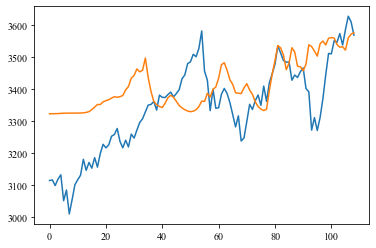

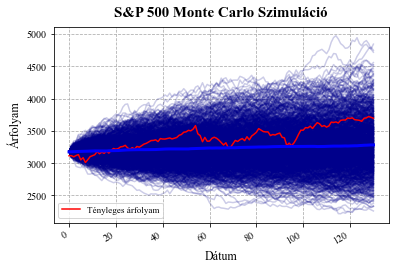

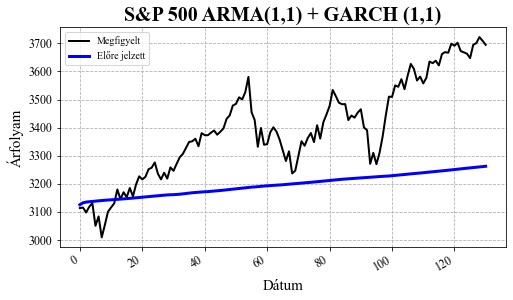

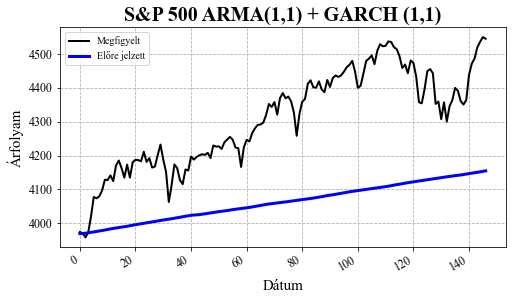

In [ ]:
# plt.plot(sample_1['Close'][:len(sample_1)-(time_step+1)])
# plt.plot(sample_1_pred_act_mid)
# plt.plot(sample_1_pred_act_up)
# plt.plot(sample_1_pred_act_down)

plt.plot(sample_1['Close'][:len(sample_1)-(time_step+1)])
plt.plot(sample_1_pred)



plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(6,4))
for i in range(1,simulation_bt):
	plt.plot(sim_values_bt[:,i], color="darkblue", alpha=0.2)
plt.plot(sample_1['Close'].values,color="red", label="Tényleges árfolyam")
plt.plot(mc_mid_pred_bt, linewidth=3, color="blue")
plt.xlabel('Dátum', fontsize=12, labelpad=5)
plt.ylabel('Árfolyam', fontsize=12, labelpad=5)
plt.title(f'{name_of_the_financial_instrument} Monte Carlo Szimuláció', fontsize=15, fontweight="bold", pad=10)
plt.legend(loc='lower left', prop={'size': 9})
plt.grid(True, linestyle='--')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
fig.autofmt_xdate()
plt.show(block=False)
plt.close()


plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(sample_1['Close'].values, label='Megfigyelt', color='black', linewidth=2)
plt.plot( difference_bt, linewidth=3, color="blue", label="Előre jelzett")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Árfolyam", fontsize=15, labelpad=5)
plt.title(f"{name_of_the_financial_instrument} ARMA({p_input},{q_input}) + {vol_type} ({p_input_garch},{q_input_garch})", fontsize=20, fontweight="bold")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.autofmt_xdate()
plt.show(block=False)
plt.close()


plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.plot(sample_2['Close'].values, label='Megfigyelt', color='black', linewidth=2)
plt.plot( difference_bt_2, linewidth=3, color="blue", label="Előre jelzett")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Árfolyam", fontsize=15, labelpad=5)
plt.title(f"{name_of_the_financial_instrument} ARMA({p_input},{q_input}) + {vol_type} ({p_input_garch},{q_input_garch})", fontsize=20, fontweight="bold")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.autofmt_xdate()
plt.show(block=False)
plt.close()


NEURAL-ARMA-GARCH Value at Risk ábra  + Kupiec alap számítások

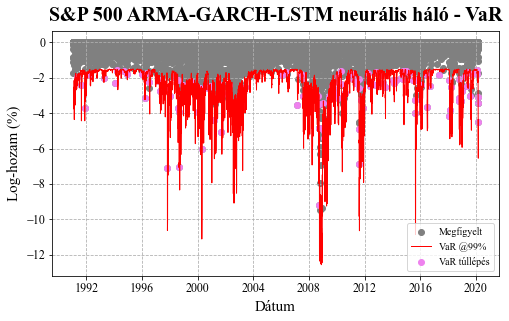

131


In [ ]:
test_var=pd.DataFrame(testPredictPlot1, index=index_col['date'])
train_var=pd.DataFrame(trainPredictPlot1, index=index_col['date'])

full_data_nn_var=train_var.fillna(test_var)
full_data_nn_var=full_data_nn_var
full_data_nn_var=full_data_nn_var.squeeze() #Series alakítás
full_data_nn_var=full_data_nn_var.interpolate()


arma_garch_nn_resid = (sigma_t-full_data_nn_var)/100

nn_var_szorzo=(temp_scatter-(full_data_nn_var*-1)).quantile(0.01)



kupiec_nn_base=full_data_nn_var*kvantilis

var_tullepes_hibrid=np.where(kupiec_base < kupiec_nn_base,1,0)

plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.scatter(index_col['date'],temp_scatter, label='Megfigyelt', color='grey')
plt.plot(index_col['date'],(full_data_nn_var*kvantilis),color="red", linewidth=1, label="VaR @99%")
plt.scatter(temp_scatter[var_tullepes_hibrid==1].index,temp_scatter[var_tullepes_hibrid==1], color="violet", label="VaR túllépés")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('Log-hozam (%)', fontsize=15, labelpad=5)
plt.title(f'{name_of_the_financial_instrument} ARMA-GARCH-LSTM neurális háló - VaR', fontsize=20, fontweight="bold", pad=10)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_neural_arma_garch_var.svg")
plt.show(block=False)
plt.close()

print(sum(var_tullepes_hibrid))


#ACF
plt.rc('font', family='Times New Roman')
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_acf(arma_garch_nn_resid.dropna(), lags=50, zero=True, title=f'{name_of_the_financial_instrument} ARMA-GARCH-LSTM ACF', ax=ax, color="red")
fig.savefig(f"plots\{name_of_the_financial_instrument}_arma_garch_LSTM_ACF.svg")
plt.clf()
plt.close()


Expected Shortfall ARMA-GARCH-LSTM

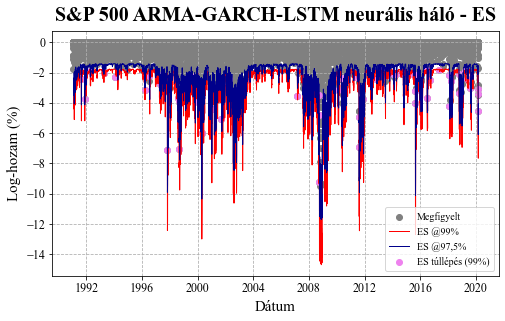

99%
65
97,5%
171


In [ ]:

kupiec_nn_base_es99=full_data_nn_var*cvar_99
kupiec_nn_base_es975=full_data_nn_var*cvar_975

es_tullepes_hibrid_99=np.where(kupiec_base < kupiec_nn_base_es99,1,0)
es_tullepes_hibrid_975=np.where(kupiec_base < kupiec_nn_base_es975,1,0)

plt.rc('font', family='Times New Roman')
fig= plt.figure(figsize=(8,4.5))
plt.scatter(index_col['date'],temp_scatter, label='Megfigyelt', color='grey')
plt.plot(index_col['date'],kupiec_nn_base_es99,color="red", linewidth=1, label="ES @99%")
plt.plot(index_col['date'],kupiec_nn_base_es975,color="darkblue", linewidth=1, label="ES @97,5%")
plt.scatter(temp_scatter[es_tullepes_hibrid_99==1].index,temp_scatter[es_tullepes_hibrid_99==1], color="violet", label="ES túllépés (99%)")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel('Log-hozam (%)', fontsize=15, labelpad=5)
plt.title(f'{name_of_the_financial_instrument} ARMA-GARCH-LSTM neurális háló - ES', fontsize=20, fontweight="bold", pad=10)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"plots\{name_of_the_financial_instrument}_neural_arma_garch_es.svg")
plt.show(block=False)
plt.close()

print("99%")
print(sum(es_tullepes_hibrid_99))
print("97,5%")
print(sum(es_tullepes_hibrid_975))

END-result plots

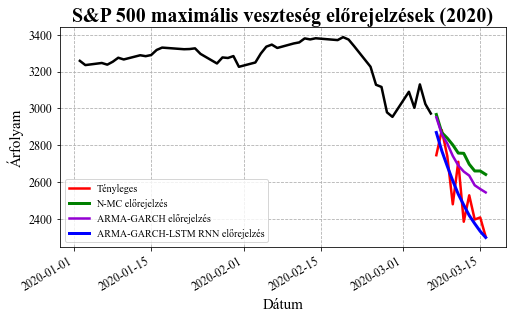

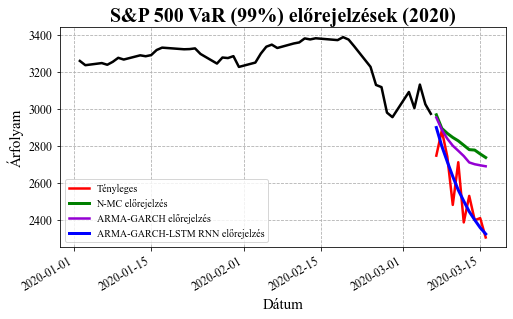

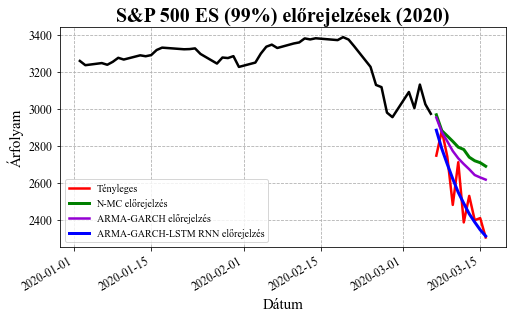

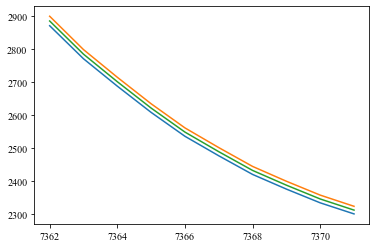

In [ ]:
fig= plt.figure(figsize=(8,4.5))
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges", linewidth=2.5)
plt.plot(fcast_dates, min_values_mc, color='green', label='N-MC előrejelzés', linewidth=3)
plt.plot(index_col['date'].loc['2020':], df['Close'].loc['2020':], color='black', linewidth=2.5)
plt.plot(fcast_dates, min_values_ar_garch, color='darkviolet', label='ARMA-GARCH előrejelzés', linewidth=2.5)
plt.plot(fcast_dates, pred_org_nn_lower1, color='blue', label='ARMA-GARCH-LSTM RNN előrejelzés', linewidth=3)
plt.title(f"{name_of_the_financial_instrument} maximális veszteség előrejelzések (2020)", fontsize=20, fontweight="bold")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Árfolyam", fontsize=15, labelpad=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--")
plt.legend(loc='lower left')
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_osszes_elorejelzes_min.svg")
plt.show(block=False)
plt.close()


pred_nn_lower_99=pred_org_nn_lower1.multiply(1.01)


fig= plt.figure(figsize=(8,4.5))
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges", linewidth=2.5)
plt.plot(fcast_dates, lower_kvant_mc_alap, color='green', label='N-MC előrejelzés', linewidth=3)
plt.plot(index_col['date'].loc['2020':], df['Close'].loc['2020':], color='black', linewidth=2.5)
plt.plot(fcast_dates, lower_kvant_garch, color='darkviolet', label='ARMA-GARCH előrejelzés', linewidth=2.5)
plt.plot(fcast_dates, pred_nn_lower_99, color='blue', label='ARMA-GARCH-LSTM RNN előrejelzés', linewidth=3)
plt.title(f"{name_of_the_financial_instrument} VaR (99%) előrejelzések (2020)", fontsize=20, fontweight="bold")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Árfolyam", fontsize=15, labelpad=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--")
plt.legend(loc='lower left')
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_osszes_elorejelzes_var.svg")
plt.show(block=False)
plt.close()


pred_nn_lower_99_ES=(pred_org_nn_lower1+pred_nn_lower_99)/2


fig= plt.figure(figsize=(8,4.5))
plt.plot(fcast_dates,Profit_Loss["Plus_10_days"],color="red", label="Tényleges", linewidth=2.5)
plt.plot(fcast_dates, ES_mc_99, color='green', label='N-MC előrejelzés', linewidth=3)
plt.plot(index_col['date'].loc['2020':], df['Close'].loc['2020':], color='black', linewidth=2.5)
plt.plot(fcast_dates, ES_garch_99, color='darkviolet', label='ARMA-GARCH előrejelzés', linewidth=2.5)
plt.plot(fcast_dates, pred_nn_lower_99_ES, color='blue', label='ARMA-GARCH-LSTM RNN előrejelzés', linewidth=3)
plt.title(f"{name_of_the_financial_instrument} ES (99%) előrejelzések (2020)", fontsize=20, fontweight="bold")
plt.xlabel('Dátum', fontsize=15, labelpad=5)
plt.ylabel("Árfolyam", fontsize=15, labelpad=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--")
plt.legend(loc='lower left')
fig.autofmt_xdate()
fig.savefig(f"plots\{name_of_the_financial_instrument}_osszes_elorejelzes_ES.svg")
plt.show(block=False)
plt.close()


Előrejelzés pontossága

In [ ]:
##Középső előrejelzési sáv pontossága
# ##NAIVE
# print("Naive: ")
# evaluate(Profit_Loss["Plus_10_days"],y_hat_naive)
# ##Monte-Carlo
# print("MC: ")
# evaluate(Profit_Loss["Plus_10_days"],mc_mid_pred)
# ##ARIMA
# print("ARIMA: ")
# evaluate(Profit_Loss["Plus_10_days"], mean_forecast)
# ##ARMA-GARCH
# print("ARMA+GARCH: ")
# evaluate(Profit_Loss["Plus_10_days"], difference)
# ##LSTM
# print("LSTM: ")
# evaluate(Profit_Loss["Plus_10_days"], pred_org_nn_middle)
# ##Hybrid
# print("LSTM+ARMA+GARCH: ")
# evaluate(Profit_Loss["Plus_10_days"], pred_org_nn_middle1)


# plt.plot(df['Log_return_garch'])
# ##Illeszkedés pontossága (ARMA-GARCH): Student-t vs Normal \\GARCH Value at Risk ábra// módosítja a Log_return_garch-ot így ehhez azt ne futtasd!
# print("ARMA-GARCH illeszkedés: ")
# evaluate(df['forecast_garch'],df['Log_return_garch'])


##Monte-Carlo
print("MC: ")
evaluate(Profit_Loss["Plus_10_days"],min_values_mc)
##ARIMA
# print("ARIMA: ")
# evaluate(Profit_Loss["Plus_10_days"], lower_limits)
##ARMA-GARCH
print("ARMA+GARCH: ")
evaluate(Profit_Loss["Plus_10_days"], min_values_ar_garch)
##LSTM
# print("LSTM: ")
# evaluate(Profit_Loss["Plus_10_days"], pred_org_nn_lower)
##Hybrid
print("LSTM+ARMA+GARCH: ")
evaluate(Profit_Loss["Plus_10_days"], pred_org_nn_lower1)

MC: 
Mean Absolute Error (MAE): 209.144
Mean Squared Error (MSE): 57625.573
Root Mean Squared Error (RMSE): 240.053
ARMA+GARCH: 
Mean Absolute Error (MAE): 153.62
Mean Squared Error (MSE): 31757.75
Root Mean Squared Error (RMSE): 178.207
LSTM+ARMA+GARCH: 
Mean Absolute Error (MAE): 89.299
Mean Squared Error (MSE): 10386.214
Root Mean Squared Error (RMSE): 101.913


(89.2991239393867, 10386.213957257, 101.91277622190948)

Kupiec-Teszt

In [ ]:
kiutes_alap=sum(tullepesek_alap)
kiutes_arma_garch=sum(var_tullepes_arma_garch)
kiutes_hibrid=sum(var_tullepes_hibrid)
napok_szama=len(temp_scatter)


#Numerikusan problémás képlet: -2*np.log(((alfa)**(napok_szama-kiutes_alap))*(1-alfa)**kiutes_alap)+2*np.log(((1-kiutes_alap/napok_szama)**(napok_szama-kiutes_alap))*(kiutes_alap/napok_szama)**kiutes_alap)

kupiec_alap= -2* ((kiutes_alap*np.log(1-alfa)+(napok_szama-kiutes_alap)*np.log(alfa)) - (kiutes_alap*np.log(kiutes_alap/napok_szama)+(napok_szama-kiutes_alap)*np.log(1-kiutes_alap/napok_szama)))
kupiec_arma_garch= -2* ((kiutes_arma_garch*np.log(1-alfa)+(napok_szama-kiutes_arma_garch)*np.log(alfa)) - (kiutes_arma_garch*np.log(kiutes_arma_garch/napok_szama)+(napok_szama-kiutes_arma_garch)*np.log(1-kiutes_arma_garch/napok_szama)))
kupiec_hibrid= -2* ((kiutes_hibrid*np.log(1-alfa)+(napok_szama-kiutes_hibrid)*np.log(alfa)) - (kiutes_hibrid*np.log(kiutes_hibrid/napok_szama)+(napok_szama-kiutes_hibrid)*np.log(1-kiutes_hibrid/napok_szama)))


#Ho: A VaR modell pontos

kritikus_ertek_kupiec_095=3.841458820694120000000000000
kritikus_ertek_kupiec_099=6.634896601021210000000000000

print("Kupiec (alap-MC modell): ")
print(kupiec_alap)
print("Kupiec (GARCH modell): ")
print(kupiec_arma_garch)
print("Kupiec (Hibrid modell): ")
print(kupiec_hibrid)


print(kiutes_alap)
print(kiutes_arma_garch)
print(kiutes_hibrid)

Kupiec (alap-MC modell): 
68.94966773719602
Kupiec (GARCH modell): 
1.0613613490029365
Kupiec (Hibrid modell): 
36.678447729731715
155
65
131


Christoffersen

In [ ]:
n0_a=napok_szama-kiutes_alap
n0_g=napok_szama-kiutes_arma_garch
n0_h=napok_szama-kiutes_hibrid

n00_a=0
n10_a=0
n01_a=0
n11_a=0
n00_g=0
n10_g=0
n01_g=0
n11_g=0
n00_h=0
n10_h=0
n01_h=0
n11_h=0

for i in range(1,len(tullepesek_alap)):
    if tullepesek_alap[i-1]==0 and tullepesek_alap[i]==0:
        n00_a=n00_a+1
    elif tullepesek_alap[i-1]==0 and tullepesek_alap[i]==1:
        n01_a=n01_a+1
    elif tullepesek_alap[i-1]==1 and tullepesek_alap[i]==0:
        n10_a=n10_a+1
    else:
        n11_a=n11_a+1

for i in range(1,len(var_tullepes_arma_garch)):
    if var_tullepes_arma_garch[i-1]==0 and var_tullepes_arma_garch[i]==0:
        n00_g=n00_g+1
    elif var_tullepes_arma_garch[i-1]==0 and var_tullepes_arma_garch[i]==1:
        n01_g=n01_g+1
    elif var_tullepes_arma_garch[i-1]==1 and var_tullepes_arma_garch[i]==0:
        n10_g=n10_g+1
    else:
        n11_g=n11_g+1

for i in range(1,len(var_tullepes_hibrid)):
    if var_tullepes_hibrid[i-1]==0 and var_tullepes_hibrid[i]==0:
        n00_h=n00_h+1
    elif var_tullepes_hibrid[i-1]==0 and var_tullepes_hibrid[i]==1:
        n01_h=n01_h+1
    elif var_tullepes_hibrid[i-1]==1 and var_tullepes_hibrid[i]==0:
        n10_h=n10_h+1
    else:
        n11_h=n11_h+1

pi01_a= n01_a / (n00_a + n01_a)
pi11_a= n11_a / (n10_a + n11_a)
pi_obs_a= (n01_a + n11_a) / (n00_a + n01_a + n10_a + n11_a)
pi01_g= n01_g / (n00_g + n01_g)
pi11_g= n11_g / (n10_g + n11_g)
pi_obs_g= (n01_g + n11_g) / (n00_g + n01_g + n10_g + n11_g)
pi01_h= n01_h / (n00_h + n01_h)
pi11_h= n11_h / (n10_h + n11_h)
pi_obs_h= (n01_h + n11_h) / (n00_h + n01_h + n10_h + n11_h)


if n10_a > n01_a:
    n01_a=n10_a
else:
    n10_a=n01_a

if n10_g > n01_g:
    n01_g=n10_g
else:
    n10_g=n01_g

if n10_h > n01_h:
    n01_h=n10_h
else:
    n10_h=n01_h

n00_a=n0_a-n10_a
n00_g=n0_g-n10_g
n00_h=n0_h-n10_h

LR_ind_alap= -2* ((kiutes_alap*np.log(kiutes_alap/napok_szama)+(napok_szama-kiutes_alap)*np.log(1-kiutes_alap/napok_szama)) - (n01_a*np.log(pi01_a)+n00_a*np.log(1-pi01_a)+n11_a*np.log(pi11_a)+n10_a*np.log(1-pi11_a)) )
LR_ind_garch= -2* ((kiutes_arma_garch*np.log(kiutes_arma_garch/napok_szama)+(napok_szama-kiutes_arma_garch)*np.log(1-kiutes_arma_garch/napok_szama)) - (n01_g*np.log(pi01_g)+n00_g*np.log(1-pi01_g)+n11_g*np.log(pi11_g)+n10_g*np.log(1-pi11_g)) )
LR_ind_hibrid= -2* ((kiutes_hibrid*np.log(kiutes_hibrid/napok_szama)+(napok_szama-kiutes_hibrid)*np.log(1-kiutes_hibrid/napok_szama)) - (n01_h*np.log(pi01_h)+n00_h*np.log(1-pi01_h)+n11_h*np.log(pi11_h)+n10_h*np.log(1-pi11_h)) )


LR_ind_alternativ_alap= -2* np.log((((1-pi_obs_a)**(n00_a+n10_a))*(pi_obs_a**(n01_a+n11_a)))/ (((1-pi01_a)**n00_a)*(pi01_a**n01_a)*((1-pi11_a)**n10_a)*(pi11_a**n11_a)))
LR_ind_alternativ_garch= -2* np.log((((1-pi_obs_g)**(n00_g+n10_g))*(pi_obs_g**(n01_g+n11_g)))/ (((1-pi01_g)**n00_g)*(pi01_g**n01_g)*((1-pi11_g)**n10_g)*(pi11_g**n11_g)))
LR_ind_alternativ_hibrid = -2* np.log((((1-pi_obs_h)**(n00_h+n10_h))*(pi_obs_h**(n01_h+n11_h)))/ (((1-pi01_h)**n00_h)*(pi01_h**n01_h)*((1-pi11_h)**n10_h)*(pi11_h**n11_h)))


print("LR_ind alap:")
print(LR_ind_alap)
print("LR_ind garch:")
print(LR_ind_garch)
print("LR_ind hibrid:")
print(LR_ind_hibrid)

print("%LR_ind_alap_alternativ%: ")
print(LR_ind_alternativ_alap)
print("%LR_ind_garch_alternativ%: ")
print(LR_ind_alternativ_garch)
print("%LR_ind_hibrid_alternativ%: ")
print(LR_ind_alternativ_hibrid)

kritikus_ertek_ind_095=3.841458820694120000000000000
kritikus_ertek_ind_099=6.634896601021210000000000000

#LR_cc
LR_cc_alap= kupiec_alap + LR_ind_alap
LR_cc_garch= kupiec_arma_garch + LR_ind_garch
LR_cc_hibrid= kupiec_hibrid + LR_ind_hibrid
print("LR_cc alap:")
print(LR_cc_alap)
print("LR_cc garch:")
print(LR_cc_garch)
print("LR_cc hibrid:")
print(LR_cc_hibrid)

LR_cc_alap_alt= kupiec_alap + LR_ind_alternativ_alap
LR_cc_garch_alt= kupiec_arma_garch + LR_ind_alternativ_garch
LR_cc_hibrid_alt= kupiec_hibrid + LR_ind_alternativ_hibrid

print("%LR_cc alap alternatív%:")
print(LR_cc_alap_alt)
print("%LR_cc garch alternatív%:")
print(LR_cc_garch_alt)
print("%LR_cc hibrid alternatív%:")
print(LR_cc_hibrid_alt)

#LR_CC kritikus érték
#khi(2)
kritikus_ertek_cc_095=5.991464547
kritikus_ertek_cc_099=9.210340372


# #Kontingencia táblázat
# print(napok_szama)
# print(n0_h)
# print(n00_h)
# print(n01_h)
# print(n10_h)
# print(n11_h)
# print(pi01_h)
# print(pi11_h)
# print(pi_obs_h)

LR_ind alap:
14.807510890894491
LR_ind garch:
5.25720504115543
LR_ind hibrid:
11.68838502115841
%LR_ind_alap_alternativ%: 
inf
%LR_ind_garch_alternativ%: 
5.257206251342426
%LR_ind_hibrid_alternativ%: 
11.688387482412748
LR_cc alap:
83.75717862809051
LR_cc garch:
6.318566390158367
LR_cc hibrid:
48.366832750890126
%LR_cc alap alternatív%:
inf
%LR_cc garch alternatív%:
6.318567600345363
%LR_cc hibrid alternatív%:
48.366835212144466


Out of sample tests

In [ ]:
from random import sample

sample_1_lr_a=np.log(sample_1['Close']/sample_1['Close'].shift(1))
sample_2_lr_a=np.log(sample_2['Close']/sample_2['Close'].shift(1))
sample_1_lr_a.reset_index(drop=True, inplace=True)
sample_2_lr_a.reset_index(drop=True, inplace=True)

for i in range(0, len(sample_1_lr_a)):
    if sample_1_lr_a[i] >= 0:
        sample_1_lr_a[i] = 0
    else:
        sample_1_lr_a[i]=sample_1_lr_a[i]

for i in range(0, len(sample_2_lr_a)):
    if sample_2_lr_a[i] >= 0:
        sample_2_lr_a[i] = 0
    else:
        sample_2_lr_a[i]=sample_2_lr_a[i]

##MC
#Sample_1
lower_kvant_mc_1=[]
#kvantilisek
temp_k_mc_1=pd.DataFrame(sim_values_bt)
#also-kvantilis
for i in range(1, len(sample_1)+1):
    lower_kvant_mc_temp_1=temp_k_mc_1.iloc[i-1,1:simulation_bt].quantile(1-alfa)
    lower_kvant_mc_1.append(lower_kvant_mc_temp_1)
lower_kvant_mc_1_lr=np.zeros(shape=len(lower_kvant_mc_1))

for i in range(0, len(lower_kvant_mc_1)-1):
    lower_kvant_mc_1_lr[i]=np.log(lower_kvant_mc_1[i+1]/lower_kvant_mc_1[i])

for i in range(0, len(lower_kvant_mc_1_lr)):
    if lower_kvant_mc_1_lr[i] >= 0:
        lower_kvant_mc_1_lr[i] = 0
mc_s1_var_sim=lower_kvant_mc_1_lr*(var_szorzo*-1)
var_tullepes_mc_s1=np.where(sample_1_lr_a< mc_s1_var_sim,1,0)
print('1. minta MC:')
print(sum(var_tullepes_mc_s1))
# plt.scatter(sample_1_lr_a.index,sample_1_lr_a, label='Megfigyelt', color='grey')
# plt.plot(sample_1_lr_a.index,mc_s1_var_sim,color="red", linewidth=1, label="VaR")
# plt.scatter(sample_1_lr_a[var_tullepes_mc_s1==1].index,sample_1_lr_a[var_tullepes_mc_s1==1], color="violet", label="VaR túllépés")
# #Sample_2
lower_kvant_mc_2=[]
#kvantilisek
temp_k_mc_2=pd.DataFrame(sim_values_bt_2)
#also-kvantilis
for i in range(1, len(sample_2)+1):
    lower_kvant_mc_temp_2=temp_k_mc_2.iloc[i-1,1:simulation_bt].quantile(1-alfa)
    lower_kvant_mc_2.append(lower_kvant_mc_temp_2)
lower_kvant_mc_2_lr=np.zeros(shape=len(lower_kvant_mc_2))

for i in range(0, len(lower_kvant_mc_2)-1):
    lower_kvant_mc_2_lr[i]=np.log(lower_kvant_mc_2[i+1]/lower_kvant_mc_2[i])

for i in range(0, len(lower_kvant_mc_2_lr)):
    if lower_kvant_mc_2_lr[i] >= 0:
        lower_kvant_mc_2_lr[i] = 0
mc_s2_var_sim=lower_kvant_mc_2_lr*(var_szorzo*-1)
var_tullepes_mc_s2=np.where(sample_2_lr_a< mc_s2_var_sim,1,0)
print('2. minta MC:')
print(sum(var_tullepes_mc_s2))
# plt.scatter(sample_2_lr_a.index,sample_2_lr_a, label='Megfigyelt', color='grey')
# plt.plot(sample_2_lr_a.index,mc_s2_var_sim,color="red", linewidth=1, label="VaR")
# plt.scatter(sample_2_lr_a[var_tullepes_mc_s2==1].index,sample_2_lr_a[var_tullepes_mc_s2==1], color="violet", label="VaR túllépés")

##ARMA-GARCH
#Sample_1
lower_kvant_garch_1_lr=np.zeros(shape=len(lower_kvant_garch_bt))

for i in range(0, len(lower_kvant_garch_bt)-1):
    lower_kvant_garch_1_lr[i]=np.log(lower_kvant_garch_bt[i+1]/lower_kvant_garch_bt[i])

for i in range(0, len(lower_kvant_garch_1_lr)):
    if lower_kvant_garch_1_lr[i] >= 0:
        lower_kvant_garch_1_lr[i] = 0
garch_sim_s1=lower_kvant_garch_1_lr*(kvantilis*-1)
var_tullepes_garch_s1=np.where(sample_1_lr_a< garch_sim_s1,1,0)
print('1. minta ARMA-GARCH:')
print(sum(var_tullepes_garch_s1))
# plt.scatter(sample_1_lr_a.index,sample_1_lr_a, label='Megfigyelt', color='grey')
# plt.plot(sample_1_lr_a.index,garch_sim_s1,color="red", linewidth=1, label="VaR")
# plt.scatter(sample_1_lr_a[var_tullepes_garch_s1==1].index,sample_1_lr_a[var_tullepes_garch_s1==1], color="violet", label="VaR túllépés")
#Sample_2
#also-kvantilis
temp_k_bt_2=pd.DataFrame(bounds_bt_2)
lower_kvant_garch_bt_2=[]
for i in range(1, len(sample_2)+1):
    lower_kvant_garch_temp_bt_2=temp_k_bt_2.iloc[i-1,1:bound_n].quantile(1-alfa)
    lower_kvant_garch_bt_2.append(lower_kvant_garch_temp_bt_2)
lower_kvant_garch_2_lr=np.zeros(shape=len(lower_kvant_garch_bt_2))

for i in range(0, len(lower_kvant_garch_bt_2)-1):
    lower_kvant_garch_2_lr[i]=np.log(lower_kvant_garch_bt_2[i+1]/lower_kvant_garch_bt_2[i])

for i in range(0, len(lower_kvant_garch_2_lr)):
    if lower_kvant_garch_2_lr[i] >= 0:
        lower_kvant_garch_2_lr[i] = 0
garch_sim_s2=lower_kvant_garch_2_lr*(kvantilis*-1)
var_tullepes_garch_s2=np.where(sample_2_lr_a< garch_sim_s2,1,0)
print('2. minta ARMA-GARCH:')
print(sum(var_tullepes_garch_s2))
# plt.scatter(sample_2_lr_a.index,sample_2_lr_a, label='Megfigyelt', color='grey')
# plt.plot(sample_2_lr_a.index,garch_sim_s2,color="red", linewidth=1, label="VaR")
# plt.scatter(sample_2_lr_a[var_tullepes_garch_s2==1].index,sample_2_lr_a[var_tullepes_garch_s2==1], color="violet", label="VaR túllépés")

##NN
#Sample 1
nn1_lr=np.zeros(shape=len(sample_1_pred))
for i in range(0, len(sample_1_pred)-1):
    nn1_lr[i]=np.log(sample_1_pred[i+1]/sample_1_pred[i])
for i in range(0, len(nn1_lr)):
    if nn1_lr[i] >= 0:
        nn1_lr[i] = 0
nn_sim_s1=nn1_lr*(kvantilis*-1)
var_tullepes_nn_s1=np.where(sample_1_lr_a[time_step+1:]< nn_sim_s1,1,0)
print('1. minta Hibrid:')
print(sum(var_tullepes_nn_s1))

nn_lr_var_s1=np.zeros(shape=len(sample_1_pred_act_down))
for i in range(0, len(sample_1_pred_act_down)-1):
    nn_lr_var_s1[i]=np.log(sample_1_pred_act_down[i+1]/sample_1_pred_act_down[i])
var_tullepes_nn_s1=np.where(sample_1_lr_a[time_step+1:]< nn_lr_var_s1,1,0)
print('1. minta Hibrid ALTERNATÍV:')
print(sum(var_tullepes_nn_s1))
# plt.scatter(sample_1_lr_a[time_step+1:].index,sample_1_lr_a[time_step+1:], label='Megfigyelt', color='grey')
# plt.plot(sample_1_lr_a[time_step+1:].index,nn_lr_var_s1,color="red", linewidth=1, label="VaR")
# plt.scatter(sample_1_lr_a[time_step+1:][var_tullepes_nn_s1==1].index,sample_1_lr_a[time_step+1:][var_tullepes_nn_s1==1], color="violet", label="VaR túllépés")

#Sample 2
nn2_lr=np.zeros(shape=len(sample_2_pred))
for i in range(0, len(sample_2_pred)-1):
    nn2_lr[i]=np.log(sample_2_pred[i+1]/sample_2_pred[i])
for i in range(0, len(nn2_lr)):
    if nn2_lr[i] >= 0:
        nn2_lr[i] = 0
nn_sim_s2=nn2_lr*(kvantilis*-1)
var_tullepes_nn_s2=np.where(sample_2_lr_a[time_step+1:]< nn_sim_s2,1,0)
print('2. minta Hibrid:')
print(sum(var_tullepes_nn_s2))

nn_lr_var_s2=np.zeros(shape=len(sample_2_pred_act_down))
for i in range(0, len(sample_2_pred_act_down)-1):
    nn_lr_var_s2[i]=np.log(sample_2_pred_act_down[i+1]/sample_2_pred_act_down[i])
var_tullepes_nn_s2=np.where(sample_2_lr_a[time_step+1:]< nn_lr_var_s2,1,0)
print('2. minta Hibrid ALTERNATÍV:')
print(sum(var_tullepes_nn_s2))
# plt.scatter(sample_2_lr_a[time_step+1:].index,sample_2_lr_a[time_step+1:], label='Megfigyelt', color='grey')
# plt.plot(sample_2_lr_a[time_step+1:].index,nn_lr_var_s2,color="red", linewidth=1, label="VaR")
# plt.scatter(sample_2_lr_a[time_step+1:][var_tullepes_nn_s2==1].index,sample_2_lr_a[time_step+1:][var_tullepes_nn_s2==1], color="violet", label="VaR túllépés")


#Kupiec
#S1
kupiec_mc_s1= -2* ((sum(var_tullepes_mc_s1)*np.log(1-alfa)+(len(sample_1)-sum(var_tullepes_mc_s1))*np.log(alfa)) - (sum(var_tullepes_mc_s1)*np.log(sum(var_tullepes_mc_s1)/len(sample_1))+(len(sample_1)-sum(var_tullepes_mc_s1))*np.log(1-sum(var_tullepes_mc_s1)/len(sample_1))))
kupiec_g_s1= -2* ((sum(var_tullepes_garch_s1)*np.log(1-alfa)+(len(sample_1)-sum(var_tullepes_garch_s1))*np.log(alfa)) - (sum(var_tullepes_garch_s1)*np.log(sum(var_tullepes_garch_s1)/len(sample_1))+(len(sample_1)-sum(var_tullepes_garch_s1))*np.log(1-sum(var_tullepes_garch_s1)/len(sample_1))))
kupiec_hibrid_s1 = -2* ((sum(var_tullepes_nn_s1)*np.log(1-alfa)+(len(sample_1_pred)-sum(var_tullepes_nn_s1))*np.log(alfa)) - (sum(var_tullepes_nn_s1)*np.log(sum(var_tullepes_nn_s1)/len(sample_1_pred))+(len(sample_1_pred)-sum(var_tullepes_nn_s1))*np.log(1-sum(var_tullepes_nn_s1)/len(sample_1_pred))))
print("Kupiec 1. minta (MC modell): ")
print(kupiec_mc_s1)
print("Kupiec 1. minta (GARCH modell): ")
print(kupiec_g_s1)
print("Kupiec 1. minta (Hibrid modell): ")
print(kupiec_hibrid_s1 )
#S2
kupiec_mc_s2= -2* ((sum(var_tullepes_mc_s2)*np.log(1-alfa)+(len(sample_2)-sum(var_tullepes_mc_s2))*np.log(alfa)) - (sum(var_tullepes_mc_s2)*np.log(sum(var_tullepes_mc_s2)/len(sample_2))+(len(sample_2)-sum(var_tullepes_mc_s2))*np.log(1-sum(var_tullepes_mc_s2)/len(sample_2))))
kupiec_g_s2= -2* ((sum(var_tullepes_garch_s2)*np.log(1-alfa)+(len(sample_2)-sum(var_tullepes_garch_s2))*np.log(alfa)) - (sum(var_tullepes_garch_s2)*np.log(sum(var_tullepes_garch_s2)/len(sample_2))+(len(sample_2)-sum(var_tullepes_garch_s2))*np.log(1-sum(var_tullepes_garch_s2)/len(sample_2))))
kupiec_hibrid_s2 = -2* ((sum(var_tullepes_nn_s2)*np.log(1-alfa)+(len(sample_2_pred)-sum(var_tullepes_nn_s2))*np.log(alfa)) - (sum(var_tullepes_nn_s2)*np.log(sum(var_tullepes_nn_s2)/len(sample_2_pred))+(len(sample_2_pred)-sum(var_tullepes_nn_s2))*np.log(1-sum(var_tullepes_nn_s2)/len(sample_2_pred))))
print("Kupiec 2. minta (MC modell): ")
print(kupiec_mc_s2)
print("Kupiec 2. minta (GARCH modell): ")
print(kupiec_g_s2)
print("Kupiec 2. minta (Hibrid modell): ")
print(kupiec_hibrid_s2 )

#Christoffersen
#Sample1
n0_a_s1=len(sample_1)-sum(var_tullepes_mc_s1)
n0_g_s1=len(sample_1)-sum(var_tullepes_garch_s1)
n0_h_s1=len(sample_1_pred)-sum(var_tullepes_nn_s1)
n00_a_s1=0
n10_a_s1=0
n01_a_s1=0
n11_a_s1=0
n00_g_s1=0
n10_g_s1=0
n01_g_s1=0
n11_g_s1=0
n00_h_s1=0
n10_h_s1=0
n01_h_s1=0
n11_h_s1=0

for i in range(1,len(var_tullepes_mc_s1)):
    if var_tullepes_mc_s1[i-1]==0 and var_tullepes_mc_s1[i]==0:
        n00_a_s1=n00_a_s1+1
    elif var_tullepes_mc_s1[i-1]==0 and var_tullepes_mc_s1[i]==1:
        n01_a_s1=n01_a_s1+1
    elif var_tullepes_mc_s1[i-1]==1 and var_tullepes_mc_s1[i]==0:
        n10_a_s1=n10_a_s1+1
    else:
        n11_a_s1=n11_a_s1+1

for i in range(1,len(var_tullepes_garch_s1)):
    if var_tullepes_garch_s1[i-1]==0 and var_tullepes_garch_s1[i]==0:
        n00_g_s1=n00_g_s1+1
    elif var_tullepes_garch_s1[i-1]==0 and var_tullepes_garch_s1[i]==1:
        n01_g_s1=n01_g_s1+1
    elif var_tullepes_garch_s1[i-1]==1 and var_tullepes_garch_s1[i]==0:
        n10_g_s1=n10_g_s1+1
    else:
        n11_g_s1=n11_g_s1+1

for i in range(1,len(var_tullepes_nn_s1)):
    if var_tullepes_nn_s1[i-1]==0 and var_tullepes_nn_s1[i]==0:
        n00_h_s1=n00_h_s1+1
    elif var_tullepes_nn_s1[i-1]==0 and var_tullepes_nn_s1[i]==1:
        n01_h_s1=n01_h_s1+1
    elif var_tullepes_nn_s1[i-1]==1 and var_tullepes_nn_s1[i]==0:
        n10_h_s1=n10_h_s1+1
    else:
        n11_h_s1=n11_h_s1+1

pi01_a_s1= n01_a_s1 / (n00_a_s1 + n01_a_s1)
pi11_a_s1= n11_a_s1 / (n10_a_s1 + n11_a_s1)
pi_obs_a_s1= (n01_a_s1 + n11_a_s1) / (n00_a_s1 + n01_a_s1 + n10_a_s1 + n11_a_s1)
pi01_g_s1= n01_g_s1 / (n00_g_s1 + n01_g_s1)
pi11_g_s1= n11_g_s1 / (n10_g_s1 + n11_g_s1)
pi_obs_g_s1= (n01_g_s1 + n11_g_s1) / (n00_g_s1 + n01_g_s1 + n10_g_s1 + n11_g_s1)
pi01_h_s1= n01_h_s1 / (n00_h_s1 + n01_h_s1)
pi11_h_s1= n11_h_s1 / (n10_h_s1 + n11_h_s1)
pi_obs_h_s1= (n01_h_s1 + n11_h_s1) / (n00_h_s1 + n01_h_s1 + n10_h_s1 + n11_h_s1)


if n10_a_s1 > n01_a_s1:
    n01_a_s1=n10_a_s1
else:
    n10_a_s1=n01_a_s1

if n10_g_s1 > n01_g_s1:
    n01_g_s1=n10_g_s1
else:
    n10_g_s1=n01_g_s1

if n10_h_s1 > n01_h_s1:
    n01_h_s1=n10_h_s1
else:
    n10_h_s1=n01_h_s1

n00_a_s1=n0_a_s1-n10_a_s1
n00_g_s1=n0_g_s1-n10_g_s1
n00_h_s1=n0_h_s1-n10_h_s1

LR_ind_alap_s1= -2* ((sum(var_tullepes_mc_s1)*np.log(sum(var_tullepes_mc_s1)/len(sample_1))+(len(sample_1)-sum(var_tullepes_mc_s1))*np.log(1-sum(var_tullepes_mc_s1)/len(sample_1))) - (n01_a_s1*np.log(pi01_a_s1)+n00_a_s1*np.log(1-pi01_a_s1)+n11_a_s1*np.log(pi11_a_s1)+n10_a_s1*np.log(1-pi11_a_s1)) )
LR_ind_garch_s1= -2* ((sum(var_tullepes_garch_s1)*np.log(sum(var_tullepes_garch_s1)/len(sample_1))+(len(sample_1)-sum(var_tullepes_garch_s1))*np.log(1-sum(var_tullepes_garch_s1)/len(sample_1))) - (n01_g_s1*np.log(pi01_g_s1)+n00_g_s1*np.log(1-pi01_g_s1)+n11_g_s1*np.log(pi11_g_s1)+n10_g_s1*np.log(1-pi11_g_s1)) )
LR_ind_hibrid_s1= -2* ((sum(var_tullepes_nn_s1)*np.log(sum(var_tullepes_nn_s1)/len(sample_1_pred))+(len(sample_1_pred)-sum(var_tullepes_nn_s1))*np.log(1-sum(var_tullepes_nn_s1)/len(sample_1_pred))) - (n01_h_s1*np.log(pi01_h_s1)+n00_h_s1*np.log(1-pi01_h_s1)+n11_h_s1*np.log(pi11_h_s1)+n10_h_s1*np.log(1-pi11_h_s1)) )

LR_ind_alternativ_alap_s1= -2* np.log((((1-pi_obs_a_s1)**(n00_a_s1+n10_a_s1))*(pi_obs_a_s1**(n01_a_s1+n11_a_s1)))/ (((1-pi01_a_s1)**n00_a_s1)*(pi01_a_s1**n01_a_s1)*((1-pi11_a_s1)**n10_a_s1)*(pi11_a_s1**n11_a_s1)))
LR_ind_alternativ_garch_s1= -2* np.log((((1-pi_obs_g_s1)**(n00_g_s1+n10_g_s1))*(pi_obs_g_s1**(n01_g_s1+n11_g_s1)))/ (((1-pi01_g_s1)**n00_g_s1)*(pi01_g_s1**n01_g_s1)*((1-pi11_g_s1)**n10_g_s1)*(pi11_g_s1**n11_g_s1)))
LR_ind_alternativ_hibrid_s1 = -2* np.log((((1-pi_obs_h_s1)**(n00_h_s1+n10_h_s1))*(pi_obs_h_s1**(n01_h_s1+n11_h_s1)))/ (((1-pi01_h_s1)**n00_h_s1)*(pi01_h_s1**n01_h_s1)*((1-pi11_h_s1)**n10_h_s1)*(pi11_h_s1**n11_h_s1)))
print('1. minta!!!!!!:')
print("LR_ind alap:")
print(LR_ind_alap_s1)
print("LR_ind garch:")
print(LR_ind_garch_s1)
print("LR_ind hibrid:")
print(LR_ind_hibrid_s1)
print("%LR_ind_alap_alternativ%: ")
print(LR_ind_alternativ_alap_s1)
print("%LR_ind_garch_alternativ%: ")
print(LR_ind_alternativ_garch_s1)
print("%LR_ind_hibrid_alternativ%: ")
print(LR_ind_alternativ_hibrid_s1)

#Sample 2
n0_a_s2=len(sample_2)-sum(var_tullepes_mc_s2)
n0_g_s2=len(sample_2)-sum(var_tullepes_garch_s2)
n0_h_s2=len(sample_2_pred)-sum(var_tullepes_nn_s2)
n00_a_s2=0
n10_a_s2=0
n01_a_s2=0
n11_a_s2=0
n00_g_s2=0
n10_g_s2=0
n01_g_s2=0
n11_g_s2=0
n00_h_s2=0
n10_h_s2=0
n01_h_s2=0
n11_h_s2=0

for i in range(1,len(var_tullepes_mc_s2)):
    if var_tullepes_mc_s2[i-1]==0 and var_tullepes_mc_s2[i]==0:
        n00_a_s2=n00_a_s2+1
    elif var_tullepes_mc_s2[i-1]==0 and var_tullepes_mc_s2[i]==1:
        n01_a_s2=n01_a_s2+1
    elif var_tullepes_mc_s2[i-1]==1 and var_tullepes_mc_s2[i]==0:
        n10_a_s2=n10_a_s2+1
    else:
        n11_a_s2=n11_a_s2+1

for i in range(1,len(var_tullepes_garch_s2)):
    if var_tullepes_garch_s2[i-1]==0 and var_tullepes_garch_s2[i]==0:
        n00_g_s2=n00_g_s2+1
    elif var_tullepes_garch_s2[i-1]==0 and var_tullepes_garch_s2[i]==1:
        n01_g_s2=n01_g_s2+1
    elif var_tullepes_garch_s2[i-1]==1 and var_tullepes_garch_s2[i]==0:
        n10_g_s2=n10_g_s2+1
    else:
        n11_g_s2=n11_g_s2+1

for i in range(1,len(var_tullepes_nn_s2)):
    if var_tullepes_nn_s2[i-1]==0 and var_tullepes_nn_s2[i]==0:
        n00_h_s2=n00_h_s2+1
    elif var_tullepes_nn_s2[i-1]==0 and var_tullepes_nn_s2[i]==1:
        n01_h_s2=n01_h_s2+1
    elif var_tullepes_nn_s2[i-1]==1 and var_tullepes_nn_s2[i]==0:
        n10_h_s2=n10_h_s2+1
    else:
        n11_h_s2=n11_h_s2+1

pi01_a_s2= n01_a_s2 / (n00_a_s2 + n01_a_s2)
pi11_a_s2= n11_a_s2 / (n10_a_s2 + n11_a_s2)
pi_obs_a_s2= (n01_a_s2 + n11_a_s2) / (n00_a_s2 + n01_a_s2 + n10_a_s2 + n11_a_s2)
pi01_g_s2= n01_g_s2 / (n00_g_s2 + n01_g_s2)
pi11_g_s2= n11_g_s2 / (n10_g_s2 + n11_g_s2)
pi_obs_g_s2= (n01_g_s2 + n11_g_s2) / (n00_g_s2 + n01_g_s2 + n10_g_s2 + n11_g_s2)
pi01_h_s2= n01_h_s2 / (n00_h_s2 + n01_h_s2)
pi11_h_s2= n11_h_s2 / (n10_h_s2 + n11_h_s2)
pi_obs_h_s2= (n01_h_s2 + n11_h_s2) / (n00_h_s2 + n01_h_s2 + n10_h_s2 + n11_h_s2)


if n10_a_s2 > n01_a_s2:
    n01_a_s2=n10_a_s2
else:
    n10_a_s2=n01_a_s2

if n10_g_s2 > n01_g_s2:
    n01_g_s2=n10_g_s2
else:
    n10_g_s2=n01_g_s2

if n10_h_s2 > n01_h_s2:
    n01_h_s2=n10_h_s2
else:
    n10_h_s2=n01_h_s2

n00_a_s2=n0_a_s2-n10_a_s2
n00_g_s2=n0_g_s2-n10_g_s2
n00_h_s2=n0_h_s2-n10_h_s2

LR_ind_alap_s2= -2* ((sum(var_tullepes_mc_s2)*np.log(sum(var_tullepes_mc_s2)/len(sample_2))+(len(sample_2)-sum(var_tullepes_mc_s2))*np.log(1-sum(var_tullepes_mc_s2)/len(sample_2))) - (n01_a_s2*np.log(pi01_a_s2)+n00_a_s2*np.log(1-pi01_a_s2)+n11_a_s2*np.log(pi11_a_s2)+n10_a_s2*np.log(1-pi11_a_s2)) )
LR_ind_garch_s2= -2* ((sum(var_tullepes_garch_s2)*np.log(sum(var_tullepes_garch_s2)/len(sample_2))+(len(sample_2)-sum(var_tullepes_garch_s2))*np.log(1-sum(var_tullepes_garch_s2)/len(sample_2))) - (n01_g_s2*np.log(pi01_g_s2)+n00_g_s2*np.log(1-pi01_g_s2)+n11_g_s2*np.log(pi11_g_s2)+n10_g_s2*np.log(1-pi11_g_s2)) )
LR_ind_hibrid_s2= -2* ((sum(var_tullepes_nn_s2)*np.log(sum(var_tullepes_nn_s2)/len(sample_2_pred))+(len(sample_2_pred)-sum(var_tullepes_nn_s2))*np.log(1-sum(var_tullepes_nn_s2)/len(sample_2_pred))) - (n01_h_s2*np.log(pi01_h_s2)+n00_h_s2*np.log(1-pi01_h_s2)+n11_h_s2*np.log(pi11_h_s2)+n10_h_s2*np.log(1-pi11_h_s2)) )

LR_ind_alternativ_alap_s2= -2* np.log((((1-pi_obs_a_s2)**(n00_a_s2+n10_a_s2))*(pi_obs_a_s2**(n01_a_s2+n11_a_s2)))/ (((1-pi01_a_s2)**n00_a_s2)*(pi01_a_s2**n01_a_s2)*((1-pi11_a_s2)**n10_a_s2)*(pi11_a_s2**n11_a_s2)))
LR_ind_alternativ_garch_s2= -2* np.log((((1-pi_obs_g_s2)**(n00_g_s2+n10_g_s2))*(pi_obs_g_s2**(n01_g_s2+n11_g_s2)))/ (((1-pi01_g_s2)**n00_g_s2)*(pi01_g_s2**n01_g_s2)*((1-pi11_g_s2)**n10_g_s2)*(pi11_g_s2**n11_g_s2)))
LR_ind_alternativ_hibrid_s2 = -2* np.log((((1-pi_obs_h_s2)**(n00_h_s2+n10_h_s2))*(pi_obs_h_s2**(n01_h_s2+n11_h_s2)))/ (((1-pi01_h_s2)**n00_h_s2)*(pi01_h_s2**n01_h_s2)*((1-pi11_h_s2)**n10_h_s2)*(pi11_h_s2**n11_h_s2)))
print('2. minta!!!!!!:')
print("LR_ind alap:")
print(LR_ind_alap_s2)
print("LR_ind garch:")
print(LR_ind_garch_s2)
print("LR_ind hibrid:")
print(LR_ind_hibrid_s2)
print("%LR_ind_alap_alternativ%: ")
print(LR_ind_alternativ_alap_s2)
print("%LR_ind_garch_alternativ%: ")
print(LR_ind_alternativ_garch_s2)
print("%LR_ind_hibrid_alternativ%: ")
print(LR_ind_alternativ_hibrid_s2)


1. minta MC:
33
2. minta MC:
34
1. minta ARMA-GARCH:
43
2. minta ARMA-GARCH:
51
1. minta Hibrid:
37
1. minta Hibrid ALTERNATÍV:
16
2. minta Hibrid:
43
2. minta Hibrid ALTERNATÍV:
23
Kupiec 1. minta (MC modell): 
158.0325243000184
Kupiec 1. minta (GARCH modell): 
231.98628572430107
Kupiec 1. minta (Hibrid modell): 
58.307314932595446
Kupiec 2. minta (MC modell): 
156.41793074002098
Kupiec 2. minta (GARCH modell): 
281.87091024141483
Kupiec 2. minta (Hibrid modell): 
94.53685058672339
1. minta!!!!!!:
LR_ind alap:
0.08836080583751027
LR_ind garch:
0.186008076659391
LR_ind hibrid:
0.0639179761778621
%LR_ind_alap_alternativ%: 
0.09096217926745373
%LR_ind_garch_alternativ%: 
0.18978588227783574
%LR_ind_hibrid_alternativ%: 
0.06551755868852245
2. minta!!!!!!:
LR_ind alap:
0.15573746112241338
LR_ind garch:
0.21290864234183005
LR_ind hibrid:
0.009543509942616879
%LR_ind_alap_alternativ%: 
0.1578058467224718
%LR_ind_garch_alternativ%: 
0.21656448616500906
%LR_ind_hibrid_alternativ%: 
0.011369060